# Projet 7 : Effectuer une prédiction de revenus

# Scénario
Vous êtes employé dans une banque, présente dans de nombreux pays à travers le monde. Celle-ci souhaite cibler de nouveaux clients potentiels, plus particulièrement les jeunes en âge d'ouvrir leur tout premier compte bancaire. Cependant, elle souhaite cibler les prospects les plus susceptibles d'avoir, plus tard dans leur vie, de hauts revenus.

L'équipe dans laquelle vous travaillez a donc reçu pour mission de créer un modèle permettant de déterminer le revenu potentiel d'une personne. Très bien.

"Quelles informations avons-nous ?" demandez-vous à votre supérieur, qui vous répond : "À vrai dire... quasiment aucune : uniquement le revenu des parents, car nous allons cibler les enfants de nos clients actuels, ainsi que le pays où ils habitent. C'est tout ! Ah oui, une dernière chose : ce modèle doit être valable pour la plupart des pays du monde. Je vous laisse méditer là-dessus… Bon courage !"

Avec aussi peu de données disponibles, cela semble être un sacré challenge !

Ainsi, vous proposez une régression linéaire avec 3 variables :

- le revenu des parents ;

- le revenu moyen du pays dans lequel habite le prospect ;

- l'indice de Gini calculé sur les revenus des habitants du pays en question.

Ce projet ne traite que de la construction et de l'interprétation du modèle. Vous n'irez pas jusqu'à la phase de prédiction.

# Les données
Ce fichier contient les données de la World Income Distribution, datée de 2008. Cette base de données est composée principalement d'études réalisées au niveau national pour bon nombre de pays, et contient les distributions de revenus des populations concernées. 


Vous téléchargerez également les indices de Gini estimés par la Banque mondiale, disponibles à [cette adresse](https://data.worldbank.org/indicator/SI.POV.GINI)
Libre à vous de trouver également d'autres sources, ou de recalculer les indices de Gini à partir de la World Income Distribution.

Vous aurez également besoin de récupérer le nombre d'habitants de chaque pays présent dans votre base.

In [243]:
# import des librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Mission 1

Résumez les données utilisées :

- année(s) des données utilisées ;

- nombre de pays présents ;

- population couverte par l'analyse (en termes de pourcentage de la population mondiale).

Les données de la World Income Distribution présentent pour chaque pays les quantiles de la distribution des revenus de leur population respective.

 **De quel type de quantiles s'agit-il (quartiles, déciles, etc.) ?**
 
 **Échantillonner une population en utilisant des quantiles est-il selon vous une bonne méthode ? Pourquoi ?**

Note :

Nous appellerons ici
chaque quantile une classe de revenu. Ainsi, la valeur de la colonne income pour un quantile donné peut être vue comme le revenu moyen des personnes appartenant à la classe de revenu correspondante à ce quantile.


L'unité utilisée dans la colonne income de la world income distribution est le $PPP.
Cette unité est calculée par la Banque mondiale, selon la méthode Eltöte-Köves-Szulc. 

Après vous être documenté, vous expliquerez à votre mentor très brièvement à quoi correspond cette unité et pourquoi elle est pertinente pour une comparaison de pays différents (Il n'est pas nécessaire de donner cette explication lors de la soutenance).

In [244]:
# creation dataframe
path = '../P7_Zaklina_Bozovic/donnees/'
df = pd.read_csv(path + 'data-projet.csv', sep=';')

In [245]:
# visualisation dataframe
df

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.00000
1,ALB,2008,2,100,916.66235,7297.00000
2,ALB,2008,3,100,1010.91600,7297.00000
3,ALB,2008,4,100,1086.90780,7297.00000
4,ALB,2008,5,100,1132.69970,7297.00000
...,...,...,...,...,...,...
11594,COD,2008,96,100,810.62330,303.19305
11595,COD,2008,97,100,911.78340,303.19305
11596,COD,2008,98,100,1057.80740,303.19305
11597,COD,2008,99,100,1286.60290,303.19305


Description des différentes colonnes :

[country] : code ISO du pays

[year_survey] : année d'étude

[quantile] : associé au nombre de quantiles. On possède donc 100 quantiles pour chaque pays. Ils sont numérotés de 1 à 100, où chacun représente 1% de la population. Le quantile numéro 1 représente la moyenne des revenus les plus faibles et le quantile numéro 100 la moyenne des revenus les plus élevés

[nb_quantiles] : nombre de quantiles, ici des centiles ou percentiles

[income] : la moyenne des revenus pour un quantile donné, dans un pays donné, au cours d'une année donnée, en $PPP

[gdpppp] : le PIB par habitants, en parité de pouvoir d'achat

In [246]:
# les information de notre dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11599 entries, 0 to 11598
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       11599 non-null  object 
 1   year_survey   11599 non-null  int64  
 2   quantile      11599 non-null  int64  
 3   nb_quantiles  11599 non-null  int64  
 4   income        11599 non-null  float64
 5   gdpppp        11399 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 543.8+ KB


Les variables income et gdpppp sont des chaînes de caractères, alors qu'elles devraient être numériques.

In [247]:
# describe metod

df.describe(include='all')

,country,year_survey,quantile,nb_quantiles,income,gdpppp
count,11599,11599.000000,11599.000000,11599.0,11599.000000,1.139900e+04
unique,116,NaN,NaN,NaN,NaN,NaN
top,PRY,NaN,NaN,NaN,NaN,NaN
freq,100,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.982757,50.500819,100.0,13538.769481,5.022128e+04
std,NaN,0.909633,28.868424,0.0,72922.343118,4.000688e+05
min,NaN,2004.000000,1.000000,100.0,16.719418,3.031931e+02
25%,NaN,2008.000000,25.500000,100.0,940.036070,2.576000e+03
50%,NaN,2008.000000,51.000000,100.0,2517.622800,7.560000e+03
75%,NaN,2008.000000,75.500000,100.0,7983.698000,1.877300e+04


On relève :

116 pays différents pour 11599 individus (il doit donc manquer une ligne)

des années d'étude s'étalant de 2004 à 2011 

des quantiles de 1 à 100

un nombre de quantiles unique (100)

des revenus moyens de 16 à 992039

des PPA de 3 à 4.3

In [248]:
# verifier valeur manquante
df.isna().sum()

country           0
year_survey       0
quantile          0
nb_quantiles      0
income            0
gdpppp          200
dtype: int64

Nous avons 200 valeur manquante dans le colonne gdpppp.

Chaque pays compte 100 indidivus, soit 100 classes de revenus, de la plus faible à la plus élevée.

In [249]:
# Données de la France
df[df['country']=='FRA'].sort_values(by='income')

,country,year_survey,quantile,nb_quantiles,income,gdpppp
3300,FRA,2008,1,100,2958.3040,30357.0
3301,FRA,2008,2,100,4412.6753,30357.0
3302,FRA,2008,3,100,4939.6350,30357.0
3303,FRA,2008,4,100,5422.9165,30357.0
3304,FRA,2008,5,100,5906.5376,30357.0
...,...,...,...,...,...,...
3395,FRA,2008,96,100,39873.5100,30357.0
3396,FRA,2008,97,100,43693.0350,30357.0
3397,FRA,2008,98,100,49489.5820,30357.0
3398,FRA,2008,99,100,60758.6130,30357.0


In [250]:
for column in df : 
    print(column, ":", df[column].nunique())

country : 116
year_survey : 7
quantile : 100
nb_quantiles : 1
income : 11598
gdpppp : 114


Remarque :


De plus, nous avons 116 pays et seulement 114 gdpppp. Il semble donc également manquer le gdpppp pour 2 pays.

Nous avons donc 114 pays dans notre dataframe, avec 100 quantiles. La valeur logiquement attendue est donc de  11 598 income (soit 11 597 valeurs puisque l'index commence à 0). Il semble donc manquait un income.




In [251]:
vm = df[df['gdpppp'].isnull()] # Individus aux gdpppp manquants
vm

,country,year_survey,quantile,nb_quantiles,income,gdpppp
5800,XKX,2008,1,100,437.89370,NaN
5801,XKX,2008,2,100,508.17133,NaN
5802,XKX,2008,3,100,591.82820,NaN
5803,XKX,2008,4,100,668.00000,NaN
5804,XKX,2008,5,100,730.40220,NaN
...,...,...,...,...,...,...
11294,PSE,2009,96,100,2763.88480,NaN
11295,PSE,2009,97,100,3077.83330,NaN
11296,PSE,2009,98,100,3449.22240,NaN
11297,PSE,2009,99,100,4165.99700,NaN


In [252]:
print(round(len(vm) / len(df) * 100, 1), '% du dataset')

1.7 % du dataset


Les 2 pays ne représentent que 1.7% de l'échantillon.

Le code ISO XKX correspond au Kosovo, son gdpppp pour l'année 2008. Ce dernier est de 7 249,35665.
De la même façon, le code ISO PSE correspond à la Palestine (sur la WID, cela correspond à "West Bank and Gaza") et son gdpppp pour l'année 2009 est de 3 708,66444.

In [253]:
# replace des valeurs manquantes avec valeur qu'on trouve

df.loc[df["country"]=="XKX"] = df.loc[df["country"]=="XKX"].replace(np.nan, 7249.35665)
df.loc[df["country"]=="PSE"] = df.loc[df["country"]=="PSE"].replace(np.nan, 3708.66444)

In [254]:
df['quantile'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

In [255]:
#recherche du pays où il manque un quantile

rsch =pd.DataFrame(df.groupby(['country'])['quantile'].mean())
rsch.sort_values(by='quantile')

,quantile
country,
ALB,50.50000
PAN,50.50000
PAK,50.50000
NPL,50.50000
NOR,50.50000
...,...
EST,50.50000
ESP,50.50000
HRV,50.50000


On peut déterminer à quel pays manque une ligne, en observant la moyenne des quantiles des pays. La Lituanie est le seul pays à ne pas afficher la moyenne correcte.

In [256]:
# Données de la France
df[df['country']=='LTU'].sort_values(by='income')

,country,year_survey,quantile,nb_quantiles,income,gdpppp
6200,LTU,2008,1,100,566.3453,17571.0
6201,LTU,2008,2,100,1147.0587,17571.0
6202,LTU,2008,3,100,1490.8408,17571.0
6203,LTU,2008,4,100,1746.5715,17571.0
6204,LTU,2008,5,100,1842.9542,17571.0
...,...,...,...,...,...,...
6294,LTU,2008,96,100,14597.0360,17571.0
6295,LTU,2008,97,100,15659.0080,17571.0
6296,LTU,2008,98,100,17883.8770,17571.0
6297,LTU,2008,99,100,22551.1700,17571.0


Lituanie  99 lignes.

In [257]:
# quel est le numéro du quantile manquant ?
for i in range(1,101):
    if i not in df[df['country'] == 'LTU']['quantile'].values : 
        print("Le quantile manquant est donc le : ", i)

Le quantile manquant est donc le :  41


On l'impute en calculant la moyenne des quantiles 40 et 42.

In [258]:
# verification quantile manquant

lituanie = df[df['country']=='LTU']
quantile_manquant =41
ltu_40_42 = lituanie[lituanie['quantile'].isin([quantile_manquant-1,quantile_manquant+1])]
ltu_40_42

,country,year_survey,quantile,nb_quantiles,income,gdpppp
6239,LTU,2008,40,100,4868.4507,17571.0
6240,LTU,2008,42,100,4895.8306,17571.0


In [259]:
# quantile 41
ltu_41 = ltu_40_42.pivot_table(index='country').reset_index()
ltu_41

,country,gdpppp,income,nb_quantiles,quantile,year_survey
0,LTU,17571.0,4882.14065,100,41,2008


On ajoute la nouvelle ligne à l'ensemble des données, pour obtenir 11600 observations.

In [260]:
df = pd.concat([df, ltu_41]).reset_index().drop(columns='index')
df

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.00000
1,ALB,2008,2,100,916.66235,7297.00000
2,ALB,2008,3,100,1010.91600,7297.00000
3,ALB,2008,4,100,1086.90780,7297.00000
4,ALB,2008,5,100,1132.69970,7297.00000
...,...,...,...,...,...,...
11595,COD,2008,97,100,911.78340,303.19305
11596,COD,2008,98,100,1057.80740,303.19305
11597,COD,2008,99,100,1286.60290,303.19305
11598,COD,2008,100,100,2243.12260,303.19305


In [261]:
# verification des valeurs manquantes
df.isna().sum()

country         0
year_survey     0
quantile        0
nb_quantiles    0
income          0
gdpppp          0
dtype: int64

In [262]:
# verification doublon pour chaque annees

df[df['year_survey']==2004]['quantile'].duplicated().sum()


0

In [263]:
# verification combine des annees nous avons dans notre dataframe

years = df['year_survey'].unique()
print(years)
print(len(years))

[2008 2009 2010 2007 2006 2011 2004]
7


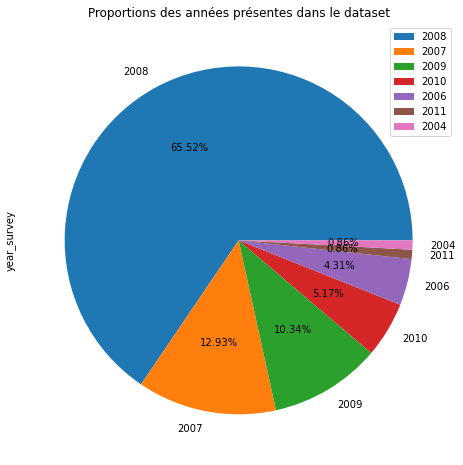

In [264]:
plt.figure(figsize=(10,8))
df['year_survey'].value_counts(normalize=True).plot(
    kind='pie',
    legend=True,
    autopct='%2.2f%%')
plt.title('Proportions des années présentes dans le dataset')
plt.savefig("P7_02_graphics/Proportions des années présentes dans le dataset.jpeg")
plt.show()

2008 represente 65 % notre dataframe.

In [265]:
## verification combine des pays nous avons dans notre dataframe

countries = df['country'].unique()
print(countries)
print(len(countries))

['ALB' 'ARG' 'ARM' 'AUT' 'AZE' 'BEL' 'BFA' 'BGD' 'BGR' 'BIH' 'BLR' 'BOL'
 'BRA' 'BTN' 'CAF' 'CAN' 'CHL' 'CHN' 'CIV' 'CMR' 'COL' 'CRI' 'CYP' 'CZE'
 'DEU' 'DNK' 'DOM' 'ECU' 'EGY' 'ESP' 'EST' 'FIN' 'FJI' 'FRA' 'GBR' 'GEO'
 'GHA' 'GIN' 'GRC' 'GTM' 'HND' 'HRV' 'HUN' 'IDN' 'IND' 'IRL' 'IRN' 'IRQ'
 'ISL' 'ISR' 'ITA' 'JOR' 'JPN' 'KAZ' 'KEN' 'KGZ' 'KHM' 'KOR' 'XKX' 'LAO'
 'LBR' 'LKA' 'LTU' 'LUX' 'LVA' 'MAR' 'MDA' 'MDG' 'MEX' 'MKD' 'MLI' 'MNE'
 'MNG' 'MOZ' 'MRT' 'MWI' 'MYS' 'NER' 'NGA' 'NIC' 'NLD' 'NOR' 'NPL' 'PAK'
 'PAN' 'PER' 'PHL' 'POL' 'PRT' 'PRY' 'ROU' 'RUS' 'SDN' 'SLV' 'SRB' 'SVK'
 'SVN' 'SWE' 'SWZ' 'SYR' 'THA' 'TJK' 'TLS' 'TUR' 'TWN' 'TZA' 'UGA' 'UKR'
 'URY' 'USA' 'VEN' 'VNM' 'PSE' 'YEM' 'ZAF' 'COD']
116


In [266]:
# verification doublon pour chaque annees

df[df['year_survey']==2006]['quantile'].duplicated().sum()

400

In [267]:
# verification doublon pour chaque annees
df[df['year_survey']==2007]['quantile'].duplicated().sum()

1400

In [268]:
df[df['year_survey']==2008]['quantile'].duplicated().sum()

7500

In [269]:
# verification doublon pour chaque annees

df[df['year_survey']==2009]['quantile'].duplicated().sum()

1100

In [270]:
# verification doublon pour chaque annees

df[df['year_survey']==2010]['quantile'].duplicated().sum()

500

In [271]:
# verification doublon pour chaque annees
df[df['year_survey']==2011]['quantile'].duplicated().sum()

0

In [272]:
# verification doublon pour chaque annees
df.groupby(by='year_survey').nunique()

,country,quantile,nb_quantiles,income,gdpppp
year_survey,,,,,
2004,1,100,1,100,1
2006,5,100,1,500,5
2007,15,100,1,1500,15
2008,76,100,1,7599,76
2009,12,100,1,1200,12
2010,6,100,1,600,6
2011,1,100,1,100,1


On observe que nous avons 76 pays dans 2008.

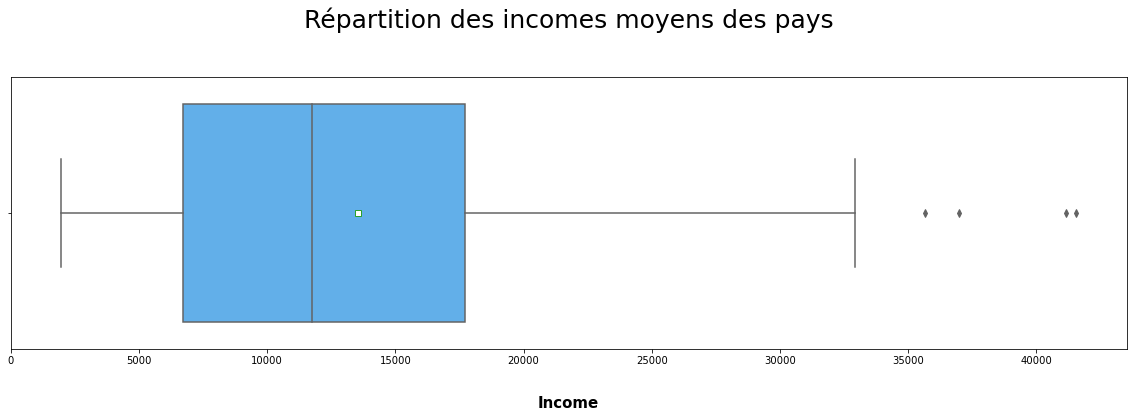

In [273]:
plt.figure(figsize = (20,5))

sns.boxplot(x='income', data=df.groupby('country')['income'].mean().reset_index(), orient='h', showmeans=True,
            palette=('#4cb2ff', '#61ba86'), meanprops={"marker":"s", "markerfacecolor":"white"})
plt.xlabel('Income', fontsize=15, labelpad=30, fontweight='bold')
plt.title('Répartition des incomes moyens des pays', fontsize=25, pad=50)
plt.savefig("P7_02_graphics/Répartition des incomes moyens des pays'.jpeg")
plt.show()

In [274]:
df["income"].describe()

count     11600.000000
mean      13538.023220
std       72919.243871
min          16.719418
25%         940.213835
50%        2517.625500
75%        7983.226500
max      992039.000000
Name: income, dtype: float64

In [275]:
df["income"].quantile([.25, .75])

0.25     940.213835
0.75    7983.226500
Name: income, dtype: float64

75% income est 11902.

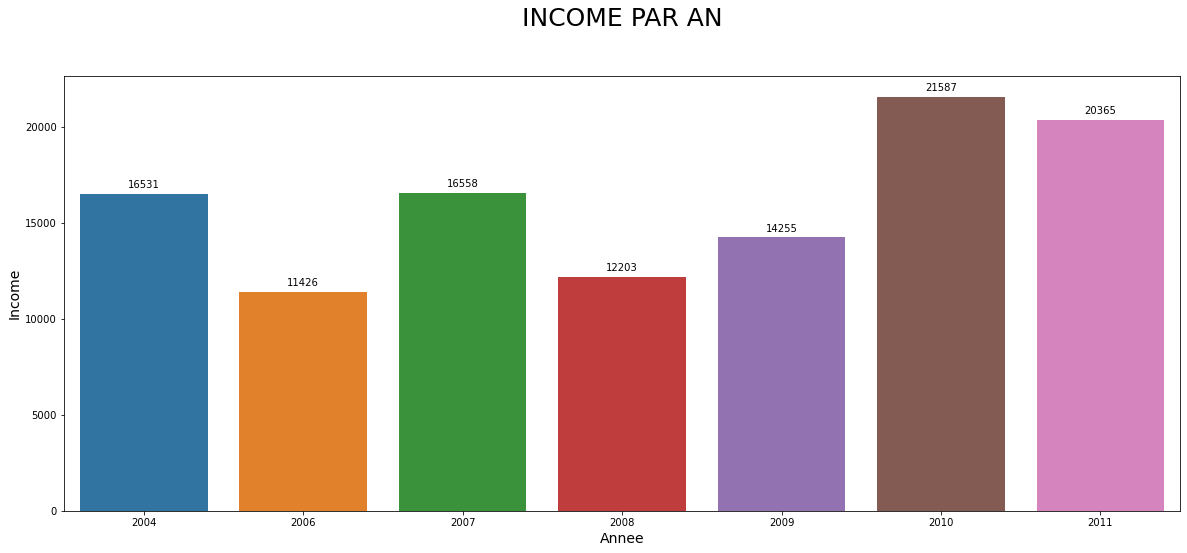

In [276]:
from numpy import mean

plt.figure(figsize = (20,8))

splot = sns.barplot(x='year_survey', y='income', data=df, estimator=mean, ci=None)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Annee", size=14)
plt.ylabel("Income", size=14)
plt.title('INCOME PAR AN', fontsize=25, pad=50)
plt.savefig("P7_02_graphics/'iNCOME PAR AN'.jpeg")
plt.show()

On voit que 2010 nous avons income/revenus le plus elevée.

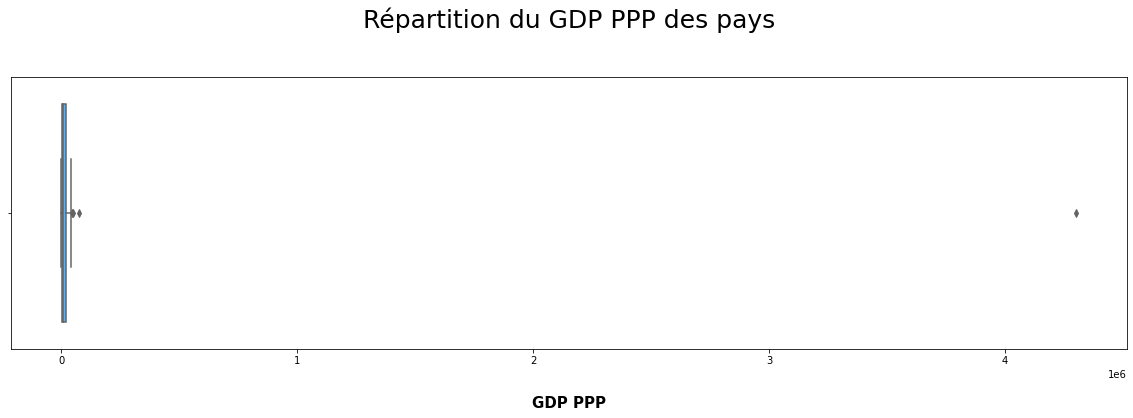

In [277]:
plt.figure(figsize = (20,5))

sns.boxplot(x='gdpppp', data=df.groupby('country')['gdpppp'].mean().reset_index(), orient='h', 
            palette=('#4cb2ff', '#61ba86'))
plt.xlabel('GDP PPP', fontsize=15, labelpad=30, fontweight='bold')
plt.title('Répartition du GDP PPP des pays', fontsize=25, pad=50)
plt.savefig("P7_02_graphics/'Répartition du GDP PPP des pays'.jpeg")
plt.show()

On voit  l'outlier situé au dessus des 4 millions.

In [278]:
df[df['gdpppp'] == df['gdpppp'].max()]

,country,year_survey,quantile,nb_quantiles,income,gdpppp
3200,FJI,2008,1,100,308.17334,4300332.0
3201,FJI,2008,2,100,384.33230,4300332.0
3202,FJI,2008,3,100,436.59265,4300332.0
3203,FJI,2008,4,100,486.81436,4300332.0
3204,FJI,2008,5,100,520.19720,4300332.0
...,...,...,...,...,...,...
3295,FJI,2008,96,100,5481.08200,4300332.0
3296,FJI,2008,97,100,6205.61400,4300332.0
3297,FJI,2008,98,100,7265.12550,4300332.0
3298,FJI,2008,99,100,9553.19200,4300332.0


Il semblerait que le gdpppp des Fiji soit une valeur abérrante. Après vérification sur la WID, le gdpppp des Fiji en 2008 est égal à 7 777,73869.

In [279]:
# changement valeur

df.loc[df["country"]=="FJI"] = df.loc[df["country"]=="FJI"].replace(4300332.0, 7777.73869)

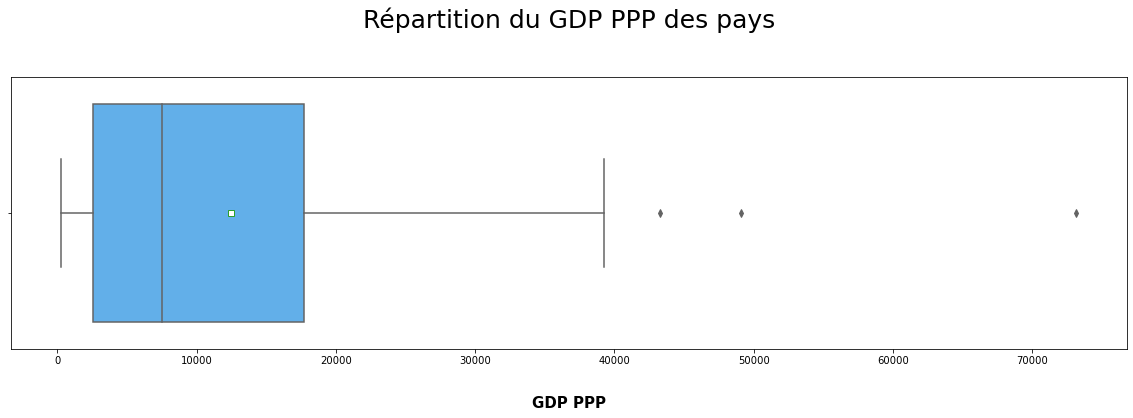

In [280]:
plt.figure(figsize = (20,5))
sns.boxplot(x='gdpppp', data=df.groupby('country')['gdpppp'].mean().reset_index(), orient='h', 
            palette=('#4cb2ff','#61ba86'),showmeans=True, meanprops={"marker":"s", "markerfacecolor":"white"})
plt.xlabel('GDP PPP', fontsize=15, labelpad=30, fontweight='bold')
plt.title('Répartition du GDP PPP des pays', fontsize=25, pad=50)
plt.savefig("P7_02_graphics/'Répartition du GDP PPP des pays - corrigée'.jpeg")

plt.show()

# Calcul de l'indice de Gini

La fonction ci-dessous permet de calculer l'indice de Gini de chaque pays, sur la base du revenu de ses quantiles.

In [281]:
def indice_gini(pays):

    pays_income = df[df['country']==pays]['income'] 
    X = np.sort(pays_income.values) 
    n = X.size # Le nombre de valeurs/quantiles dans le vecteur (100)
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i+1)*yi for i, yi in enumerate(X)])
    return coef_*weighted_sum/(X.sum()) - const_
    
print('Indice de Gini de la France :', indice_gini('FRA'))

Indice de Gini de la France : 0.3290962387603571


In [282]:
indice_gini('COD')

0.9703663598005954

In [283]:
gini = []
for i in df['country'].unique():
    gini.append(indice_gini(i))

gini = pd.DataFrame(
    gini, 
    df['country'].unique()
    ).reset_index().rename(
    columns={'index': 'country', 0: 'gini'})
gini

,country,gini
0,ALB,0.304624
1,ARG,0.773172
2,ARM,0.863199
3,AUT,0.278279
4,AZE,0.312321
...,...,...
111,VNM,0.930697
112,PSE,0.937173
113,YEM,0.940101
114,ZAF,0.890155


In [284]:
gini.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  116 non-null    object 
 1   gini     116 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.9+ KB


In [285]:
position_france = gini[gini['country']=='FRA']
print('France :\n', 
        position_france.index[0], 'ème pays le plus égalitaire\n',
        len(gini) + 1 - position_france.index[0], 
        'ème pays le plus inégalitaire\nIndice de Gini :',
        round(float(position_france['gini']), 2), '\n')

France :
 33 ème pays le plus égalitaire
 84 ème pays le plus inégalitaire
Indice de Gini : 0.33 



In [286]:
df = df.merge(gini, on='country', how='left')
df

,country,year_survey,quantile,nb_quantiles,income,gdpppp,gini
0,ALB,2008,1,100,728.89795,7297.00000,0.304624
1,ALB,2008,2,100,916.66235,7297.00000,0.304624
2,ALB,2008,3,100,1010.91600,7297.00000,0.304624
3,ALB,2008,4,100,1086.90780,7297.00000,0.304624
4,ALB,2008,5,100,1132.69970,7297.00000,0.304624
...,...,...,...,...,...,...,...
11595,COD,2008,97,100,911.78340,303.19305,0.970366
11596,COD,2008,98,100,1057.80740,303.19305,0.970366
11597,COD,2008,99,100,1286.60290,303.19305,0.970366
11598,COD,2008,100,100,2243.12260,303.19305,0.970366


L'indice (ou coefficient) de Gini est un indicateur synthétique permettant de rendre compte du niveau d'inégalité pour une variable et sur une population donnée. Il varie entre 0 (égalité parfaite) et 1 (inégalité extrême). Entre 0 et 1, l'inégalité est d'autant plus forte que l'indice de Gini est élevé.

Il est égal à 0 dans une situation d'égalité parfaite où la variable prend une valeur identique sur l’ensemble de la population. À l'autre extrême, il est égal à 1 dans la situation la plus inégalitaire possible, où la variable vaut 0 sur toute la population à l’exception d’un seul individu. 

In [287]:
# dataframe pour population

path = '../P7_Zaklina_Bozovic/donnees/'
population = pd.read_csv(path +'population.csv', skiprows=4)
population.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54208.0,55434.0,56234.0,56699.0,57029.0,57357.0,...,102565.0,103165.0,103776.0,104339.0,104865.0,105361.0,105846.0,106310.0,106766.0,NaN
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130836765.0,134159786.0,137614644.0,141202036.0,144920186.0,148769974.0,...,547482863.0,562601578.0,578075373.0,593871847.0,609978946.0,626392880.0,643090131.0,660046272.0,677243299.0,NaN
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996967.0,9169406.0,9351442.0,9543200.0,9744772.0,9956318.0,...,31161378.0,32269592.0,33370804.0,34413603.0,35383028.0,36296111.0,37171922.0,38041757.0,38928341.0,NaN
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,96396419.0,98407221.0,100506960.0,102691339.0,104953470.0,107289875.0,...,370243017.0,380437896.0,390882979.0,401586651.0,412551299.0,423769930.0,435229381.0,446911598.0,458803476.0,NaN
4,Angola,AGO,"Population, total",SP.POP.TOTL,5454938.0,5531451.0,5608499.0,5679409.0,5734995.0,5770573.0,...,25107925.0,26015786.0,26941773.0,27884380.0,28842482.0,29816769.0,30809787.0,31825299.0,32866268.0,NaN


Je vais récupèrer d'abord les années couvertes par la dataframe principale.

In [288]:
years = list(map(str, sorted(df['year_survey'].unique())))
years

['2004', '2006', '2007', '2008', '2009', '2010', '2011']

In [289]:
columns = ['Country Code', 'Country Name']
population = population[columns + years]
population

,Country Code,Country Name,2004,2006,2007,2008,2009,2010,2011
0,ABW,Aruba,98744.0,100830.0,101226.0,101362.0,101452.0,101665.0,102050.0
1,AFE,Africa Eastern and Southern,441630149.0,465581372.0,478166911.0,491173160.0,504604672.0,518468229.0,532760424.0
2,AFG,Afghanistan,24726689.0,26433058.0,27100542.0,27722281.0,28394806.0,29185511.0,30117411.0
3,AFW,Africa Western and Central,297353098.0,313985474.0,322741656.0,331772330.0,341050537.0,350556886.0,360285439.0
4,AGO,Angola,18758138.0,20149905.0,20905360.0,21695636.0,22514275.0,23356247.0,24220660.0
...,...,...,...,...,...,...,...,...,...
261,XKX,Kosovo,1704622.0,1719536.0,1733404.0,1747383.0,1761474.0,1775680.0,1791000.0
262,YEM,"Yemen, Rep.",19540096.0,20687648.0,21282514.0,21892149.0,22516464.0,23154854.0,23807586.0
263,ZAF,South Africa,47291610.0,48489464.0,49119766.0,49779472.0,50477013.0,51216967.0,52003759.0
264,ZMB,Zambia,11550641.0,12173518.0,12502958.0,12848531.0,13215142.0,13605986.0,14023199.0


In [290]:
# calculation somme des population pour chaque année

sums = population.select_dtypes(pd.np.number).sum().rename('total')
population=population.append(sums)
population

,Country Code,Country Name,2004,2006,2007,2008,2009,2010,2011
0,ABW,Aruba,9.874400e+04,1.008300e+05,1.012260e+05,1.013620e+05,1.014520e+05,1.016650e+05,1.020500e+05
1,AFE,Africa Eastern and Southern,4.416301e+08,4.655814e+08,4.781669e+08,4.911732e+08,5.046047e+08,5.184682e+08,5.327604e+08
2,AFG,Afghanistan,2.472669e+07,2.643306e+07,2.710054e+07,2.772228e+07,2.839481e+07,2.918551e+07,3.011741e+07
3,AFW,Africa Western and Central,2.973531e+08,3.139855e+08,3.227417e+08,3.317723e+08,3.410505e+08,3.505569e+08,3.602854e+08
4,AGO,Angola,1.875814e+07,2.014990e+07,2.090536e+07,2.169564e+07,2.251428e+07,2.335625e+07,2.422066e+07
...,...,...,...,...,...,...,...,...,...
262,YEM,"Yemen, Rep.",1.954010e+07,2.068765e+07,2.128251e+07,2.189215e+07,2.251646e+07,2.315485e+07,2.380759e+07
263,ZAF,South Africa,4.729161e+07,4.848946e+07,4.911977e+07,4.977947e+07,5.047701e+07,5.121697e+07,5.200376e+07
264,ZMB,Zambia,1.155064e+07,1.217352e+07,1.250296e+07,1.284853e+07,1.321514e+07,1.360599e+07,1.402320e+07
265,ZWE,Zimbabwe,1.201991e+07,1.215550e+07,1.225592e+07,1.237955e+07,1.252696e+07,1.269773e+07,1.289432e+07


J'ai ajouté un ligne avec total des populations pour chaque colonnes/chaque ans.

In [291]:
population.duplicated().sum()

0

In [292]:
# prepare dataframe pour le population

population = population.set_index(
    ['Country Code', 'Country Name']
    ).stack().reset_index().rename(
    columns={'level_2': 'year_survey', 0: 'population', 'Country Code': 'country'})
population['year_survey'] = population['year_survey'].astype(int)
population

,country,Country Name,year_survey,population
0,ABW,Aruba,2004,9.874400e+04
1,ABW,Aruba,2006,1.008300e+05
2,ABW,Aruba,2007,1.012260e+05
3,ABW,Aruba,2008,1.013620e+05
4,ABW,Aruba,2009,1.014520e+05
...,...,...,...,...
1857,NaN,NaN,2007,7.116898e+10
1858,NaN,NaN,2008,7.210972e+10
1859,NaN,NaN,2009,7.305498e+10
1860,NaN,NaN,2010,7.400378e+10


In [293]:
population['population'].sum()

1007897017254.0

In [294]:
df = df.merge(population, on=['country', 'year_survey'], how='left')
df

,country,year_survey,quantile,nb_quantiles,income,gdpppp,gini,Country Name,population
0,ALB,2008,1,100,728.89795,7297.00000,0.304624,Albania,2947314.0
1,ALB,2008,2,100,916.66235,7297.00000,0.304624,Albania,2947314.0
2,ALB,2008,3,100,1010.91600,7297.00000,0.304624,Albania,2947314.0
3,ALB,2008,4,100,1086.90780,7297.00000,0.304624,Albania,2947314.0
4,ALB,2008,5,100,1132.69970,7297.00000,0.304624,Albania,2947314.0
...,...,...,...,...,...,...,...,...,...
11595,COD,2008,97,100,911.78340,303.19305,0.970366,"Congo, Dem. Rep.",60411195.0
11596,COD,2008,98,100,1057.80740,303.19305,0.970366,"Congo, Dem. Rep.",60411195.0
11597,COD,2008,99,100,1286.60290,303.19305,0.970366,"Congo, Dem. Rep.",60411195.0
11598,COD,2008,100,100,2243.12260,303.19305,0.970366,"Congo, Dem. Rep.",60411195.0


In [295]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11600 entries, 0 to 11599
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       11600 non-null  object 
 1   year_survey   11600 non-null  int64  
 2   quantile      11600 non-null  int64  
 3   nb_quantiles  11600 non-null  int64  
 4   income        11600 non-null  float64
 5   gdpppp        11600 non-null  float64
 6   gini          11600 non-null  float64
 7   Country Name  11500 non-null  object 
 8   population    11500 non-null  float64
dtypes: float64(4), int64(3), object(2)
memory usage: 906.2+ KB


On voit que nous avons des valeurs manquantes dans les colonnes Country Name et population.

In [296]:
df[df['population'].isnull()]

,country,year_survey,quantile,nb_quantiles,income,gdpppp,gini,Country Name,population
10399,TWN,2008,1,100,3477.1800,25342.0,0.314801,NaN,NaN
10400,TWN,2008,2,100,4740.2637,25342.0,0.314801,NaN,NaN
10401,TWN,2008,3,100,5331.3013,25342.0,0.314801,NaN,NaN
10402,TWN,2008,4,100,5761.6577,25342.0,0.314801,NaN,NaN
10403,TWN,2008,5,100,6093.2017,25342.0,0.314801,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10494,TWN,2008,96,100,38123.4600,25342.0,0.314801,NaN,NaN
10495,TWN,2008,97,100,41663.7900,25342.0,0.314801,NaN,NaN
10496,TWN,2008,98,100,46650.5820,25342.0,0.314801,NaN,NaN
10497,TWN,2008,99,100,54016.9920,25342.0,0.314801,NaN,NaN


On voit que nous avons des valeurs manquantes pour le population de Taïwan.

[Population de la Taïwan en 2008](https://countryeconomy.com/demography/population/taiwan?year=2008)

In [297]:
# valeurs de nan
df.loc[df['country'] == 'TWN', 'country_name'] = 'Taïwan'
df.loc[df['country'] == 'TWN', 'population'] = 23037000
df['population'] = df['population'].astype(int)

#population dans notre df
df.groupby('country')['population'].unique().reset_index()['population'].astype(int).sum()

6188499326

[Population, Total - World Bank](https://data.worldbank.org/indicator/SP.POP.TOTL?end=2011&start=2004&type=shaded&view=chart)

In [298]:
df.nunique()

country           116
year_survey         7
quantile          100
nb_quantiles        1
income          11599
gdpppp            116
gini              116
Country Name      115
population        116
country_name        1
dtype: int64

In [299]:
#average population de 2004 a 2011 (2005 excluded)
print(round((6.840 + 7.024 + 7.116 + 6.757 + 7.210 + 7.305 + 7.495) / 7, 4))

#population covered by the analysis
print(round(6.1885 * 100 / 7.1067,2), '%')

7.1067
87.08 %


# Méthode & définition
De quel type de quantiles s'agit-il (quartiles, déciles, etc.) ? Échantillonner une population en utilisant des quantiles est-il selon vous une bonne méthode ? Pourquoi ?

L'unité utilisée dans la colonne income de la world income distribution est le $PPP. Cette unité est calculée par la Banque mondiale, selon la méthode Eltöte-Köves-Szulc. Après vous être documenté, vous expliquerez à votre mentor très brièvement à quoi correspond cette unité et pourquoi elle est pertinente pour une comparaison de pays différents (Il n'est pas nécessaire de donner cette explication lors de la soutenance).

**Méthode :**

L’approche statique de la mesure des inégalités s’appuie sur différents outils qui permettent d’appréhender la dispersion des revenus au sein d’une population étudiée. L’utilisation de quantiles permet d’ordonner la population étudiée en groupes égaux par ordre croissant, en fonction de la valeur que prend la dispersion étudiée dans ces derniers. Lorsque la population étudiée est découpée en tranches de 1%, il s'agit donc de centiles (ou percentiles). Le dernier centile de la population, représente ainsi les 1% des ménages les plus aisés.


Echantillonner une population en quantile me parait donc être une bonne méthode. Le fait que la population soit découpée en centiles permet de conserver une partie de l'information plus homogène que si on l'avait découpé en déciles par exemple. Cela nous permet également de définir des classes de revenu de la même manière dans tous les pays.


De plus, d'autres outils, comme l'indice de Gini et la courbe de Lorenz, permettent également d'appréhender la dispersion des révenus d'une population. 


Définition de l'unité $PPP :

Parité de pouvoir d'achat (Purchasing Pwer Parity) est un taux de conversion monétaire qui permet d'exprimer dans une unité commune les pouvoirs d'achat des différentes monnaies. Ce taux exprime le rapport entre la quantité d'unités monétaires nécessaire dans des pays différents pour se procurer le même « panier » de biens et de services.

## Mission 2

- Montrez la diversité des pays en termes de distribution de revenus à l'aide d'un graphique. Celui-ci représentera le revenu moyen (axe des ordonnées, sur une échelle logarithmique) de chacune des classes de revenus (axe des abscisses) pour 5 à 10 pays que vous aurez choisis pour montrer la diversité des cas.

- Représentez la courbe de Lorenz de chacun des pays choisis.

- Pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans.

- Classez les pays par indice de Gini. Donnez la moyenne, les 5 pays ayant l'indice de Gini le plus élevé et les 5 pays ayant l'indice de Gini le plus faible. En quelle position se trouve la France ?

# Diversité des pays

In [300]:
y = 2008

In [301]:
# grouper

data_compar= df[df['year_survey']==y].groupby('country').mean()

In [302]:
# visulation dataframe
data_compar.head()

,year_survey,quantile,nb_quantiles,income,gdpppp,gini,population
country,,,,,,,
ALB,2008.0,50.5,100.0,2994.829902,7297.0,0.304624,2947314
ARG,2008.0,50.5,100.0,15022.780574,13220.0,0.773172,40080159
ARM,2008.0,50.5,100.0,9469.673645,5611.0,0.863199,2907615
AUT,2008.0,50.5,100.0,16637.600204,36193.0,0.278279,8321496
AZE,2008.0,50.5,100.0,2357.429023,8101.0,0.312321,8763400


In [303]:
# describe method
data_compar.describe()

,year_survey,quantile,nb_quantiles,income,gdpppp,gini,population
count,76.0,76.0,76.0,76.000000,76.000000,76.000000,7.600000e+01
mean,2008.0,50.5,100.0,12203.013235,17042.065189,0.507986,3.061493e+07
std,0.0,0.0,0.0,7197.658440,14025.878879,0.266761,5.039113e+07
min,2008.0,50.5,100.0,2176.269035,303.193050,0.230731,3.174140e+05
25%,2008.0,50.5,100.0,6249.174651,7117.267487,0.298759,4.424768e+06
50%,2008.0,50.5,100.0,11656.439706,11843.000000,0.356659,9.624721e+06
75%,2008.0,50.5,100.0,16534.567803,27141.500000,0.831044,3.861436e+07
max,2008.0,50.5,100.0,36968.947776,73127.000000,0.970366,3.040940e+08


In [304]:
# le choix des pays

pays_class_1 = data_compar[data_compar['income']<6423]

In [305]:
pays_class_1.reset_index().country

0     ALB
1     AZE
2     BGR
3     BLR
4     CRI
5     ECU
6     HUN
7     IRN
8     JOR
9     KAZ
10    PER
11    POL
12    ROU
13    SLV
14    SRB
15    SVK
16    TUR
17    UKR
18    URY
19    XKX
Name: country, dtype: object

In [306]:
# le choix des pays 
pays_class_2 = data_compar[(data_compar['income']>6423) & (data_compar['income']<11727)].reset_index().country

In [307]:
pays_class_2

0     ARM
1     BOL
2     CIV
3     COD
4     CZE
5     DOM
6     EST
7     FJI
8     HND
9     HRV
10    ISR
11    KGZ
12    LTU
13    LVA
14    MNE
15    PRT
16    PRY
17    RUS
Name: country, dtype: object

In [308]:
# le choix des pays 
pays_class_3 = data_compar[(data_compar['income']<16568) & (data_compar['income']>11727)].reset_index().country

In [309]:
pays_class_3

0     ARG
1     BEL
2     BRA
3     COL
4     ESP
5     FIN
6     GRC
7     IRQ
8     ITA
9     KOR
10    MDA
11    MEX
12    MKD
13    MOZ
14    PAK
15    SVN
16    SWE
17    TWN
18    YEM
Name: country, dtype: object

In [310]:
data_compar.head()

,year_survey,quantile,nb_quantiles,income,gdpppp,gini,population
country,,,,,,,
ALB,2008.0,50.5,100.0,2994.829902,7297.0,0.304624,2947314
ARG,2008.0,50.5,100.0,15022.780574,13220.0,0.773172,40080159
ARM,2008.0,50.5,100.0,9469.673645,5611.0,0.863199,2907615
AUT,2008.0,50.5,100.0,16637.600204,36193.0,0.278279,8321496
AZE,2008.0,50.5,100.0,2357.429023,8101.0,0.312321,8763400


# Sélection des pays

In [311]:
data_compar.reset_index(inplace=True)

In [312]:
#create df with only selected countries
selected_countries = data_compar[(data_compar['country'] == 'SLO') ^ (data_compar['country'] == 'RUS') ^ 
                          (data_compar['country'] == 'ITA') ^ (data_compar['country'] == 'GRC') ^ (data_compar['country'] == 'FRA') ^
                        (data_compar['country'] == 'USA')]

In [313]:
selected_countries_p = df[(df['country'] == 'SLO') ^ (df['country'] == 'RUS') ^ 
                          (df['country'] == 'ITA') ^ (df['country'] == 'GRC') ^ (df['country'] == 'FRA') ^
                        (df['country'] == 'USA')]

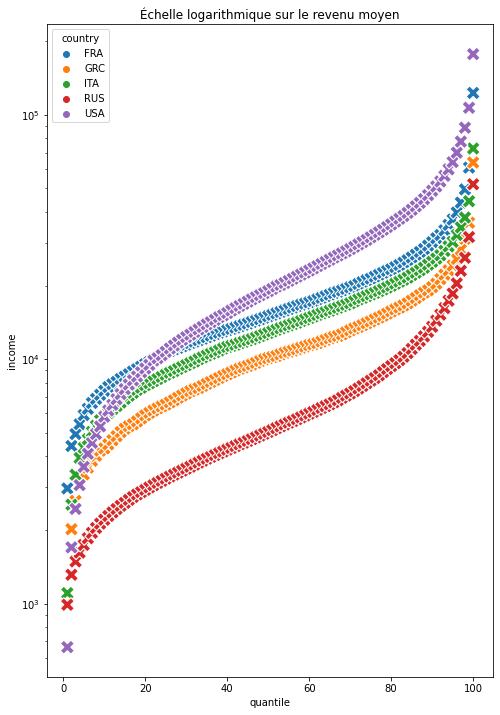

In [314]:
plt.figure(figsize=(8, 12))
ax = sns.scatterplot(
    data=selected_countries_p, x='quantile', y='income', 
    hue='country', marker='X', s=200)
ax.set(yscale="log") # échelle logarithmique sur le revenu moyen (axe des ordonnées)
plt.title('Échelle logarithmique sur le revenu moyen')
plt.savefig("P7_02_graphics/'Échelle logarithmique sur le revenu moyen'.jpeg")
plt.show()

 USA 
 
 
 ◆ les plus forts revenus 
 
 ◆ parmi les revenus les plus faibles 
 
 France 
 
 ◆ Les classes les plus basses ont parmi les plus hauts 
revenus entre pays

 ◆ Les classes les plus hautes ont parmi les plus hauts 
   revenus entre pays

Russie : la plus forte amplitude

No handles with labels found to put in legend.


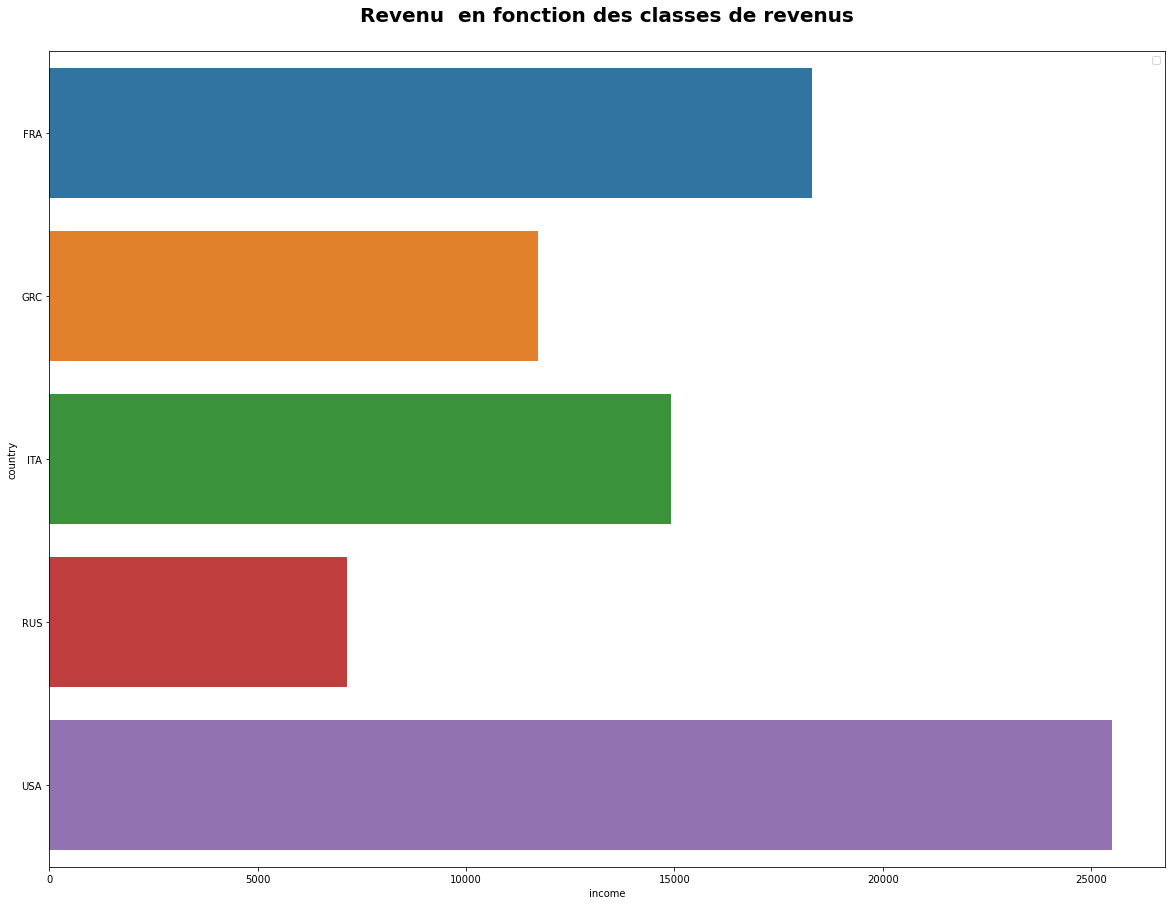

In [315]:
# graphics
plt.figure(figsize=(20, 15))
sns.barplot(x='income', y='country',data=selected_countries)
plt.xlabel("income")
plt.ylabel("country")

plt.title("Revenu  en fonction des classes de revenus", pad=30, fontsize=20, fontweight='bold')
plt.legend()
plt.savefig("P7_02_graphics/'Revenu  en fonction des classes de revenus'.jpeg")

plt.show()

On observe que USA a le plus elevée income des autres pays.


In [316]:
selected_countries

,country,year_survey,quantile,nb_quantiles,income,gdpppp,gini,population
26,FRA,2008.0,50.5,100.0,18309.407545,30357.0,0.329096,64374979
29,GRC,2008.0,50.5,100.0,11727.274287,27123.0,0.329403,11077841
38,ITA,2008.0,50.5,100.0,14925.214922,28170.0,0.317308,58826731
62,RUS,2008.0,50.5,100.0,7156.770709,14766.0,0.416691,142742366
72,USA,2008.0,50.5,100.0,25503.581661,43261.0,0.431799,304093966


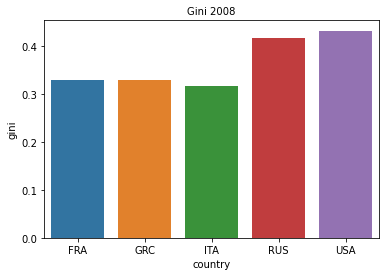

In [317]:
# gini pour le pays selectionne

sns.barplot(x='country', y='gini',data = selected_countries)
plt.title('Gini 2008',fontsize=10)
plt.savefig("P7_02_graphics/'Gini 2008'.jpeg")
plt.show()

In [318]:
#diversity of countries
#plt.figure(figsize=(20, 15))

#sns.lineplot(x=selected_countries['quantile'], y=selected_countries['income'], hue=selected_countries['country'], 
             #data=selected_countries, palette='bright')
#plt.xlabel("Quantiles")
#plt.ylabel("Revenu moyen")
#plt.yscale("log")

#plt.legend()
#plt.title("Revenu moyen en fonction des classes de revenus", pad=30, fontsize=20, fontweight='bold')


#plt.show()

# Indice de Gini

In [319]:
path = '../P7_Zaklina_Bozovic/donnees/'
gini = pd.read_csv(path + 'gini.csv', error_bad_lines=False, decimal=",")
gini

,Country Name,Country Code,2004,2005,2006,2007,2008,2009,2010,2011
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,NaN,NaN,NaN,NaN,42.7,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,NaN,31.2,30.3,NaN,NaN,31.8,33.3,27.8
262,"Yemen, Rep.",YEM,NaN,34.7,NaN,NaN,NaN,NaN,NaN,NaN
263,South Africa,ZAF,NaN,64.8,NaN,NaN,63,NaN,63.4,NaN
264,Zambia,ZMB,54.3,NaN,54.6,NaN,NaN,NaN,55.6,NaN


In [320]:
gini.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country Name  266 non-null    object
 1   Country Code  266 non-null    object
 2   2004          70 non-null     object
 3   2005          76 non-null     object
 4   2006          75 non-null     object
 5   2007          70 non-null     object
 6   2008          73 non-null     object
 7   2009          78 non-null     object
 8   2010          83 non-null     object
 9   2011          77 non-null     object
dtypes: object(10)
memory usage: 20.9+ KB


Problème rencontré : Pour certains pays, on ne dispose d'aucunes informations sur l'index de gini sur aucune année (2004 - 2011). Cela contraint à selectionner le ou les 2 pays suivants sur la liste, nottament pour les derniers pays possédant un income et un gdpppp faible (majoritairement des pays d'Afrique, où il est difficile de récolter des données.

Bien que pour l'Afrique du Sud on ne possède que deux index de gini sur les années étudiées, cette dernière étant assez représentative en terme de disparité.

In [321]:
#list of countries
labels= ['FRA','GRC','ITA','RUS', 'USA']
#courbe de Lorenz

income_FRA = df[df['country']=='FRA'].income.values
lorenz_FRA = np.cumsum(np.sort(income_FRA)) / income_FRA.sum()
lorenz_FRA = np.append([0],lorenz_FRA)

income_GRC = df[df['country']=='GRC'].income.values
lorenz_GRC = np.cumsum(np.sort(income_GRC)) / income_GRC.sum()
lorenz_GRC = np.append([0],lorenz_GRC)

income_ITA = df[df['country']=='ITA'].income.values
lorenz_ITA = np.cumsum(np.sort(income_ITA)) / income_ITA.sum()
lorenz_ITA = np.append([0],lorenz_ITA)

income_RUS = df[df['country']=='RUS'].income.values
lorenz_RUS  = np.cumsum(np.sort(income_RUS )) / income_RUS.sum()
lorenz_RUS  = np.append([0],lorenz_RUS)

income_USA = df[df['country']=='USA'].income.values
lorenz_USA  = np.cumsum(np.sort(income_USA )) / income_USA.sum()
lorenz_USA  = np.append([0],lorenz_USA)



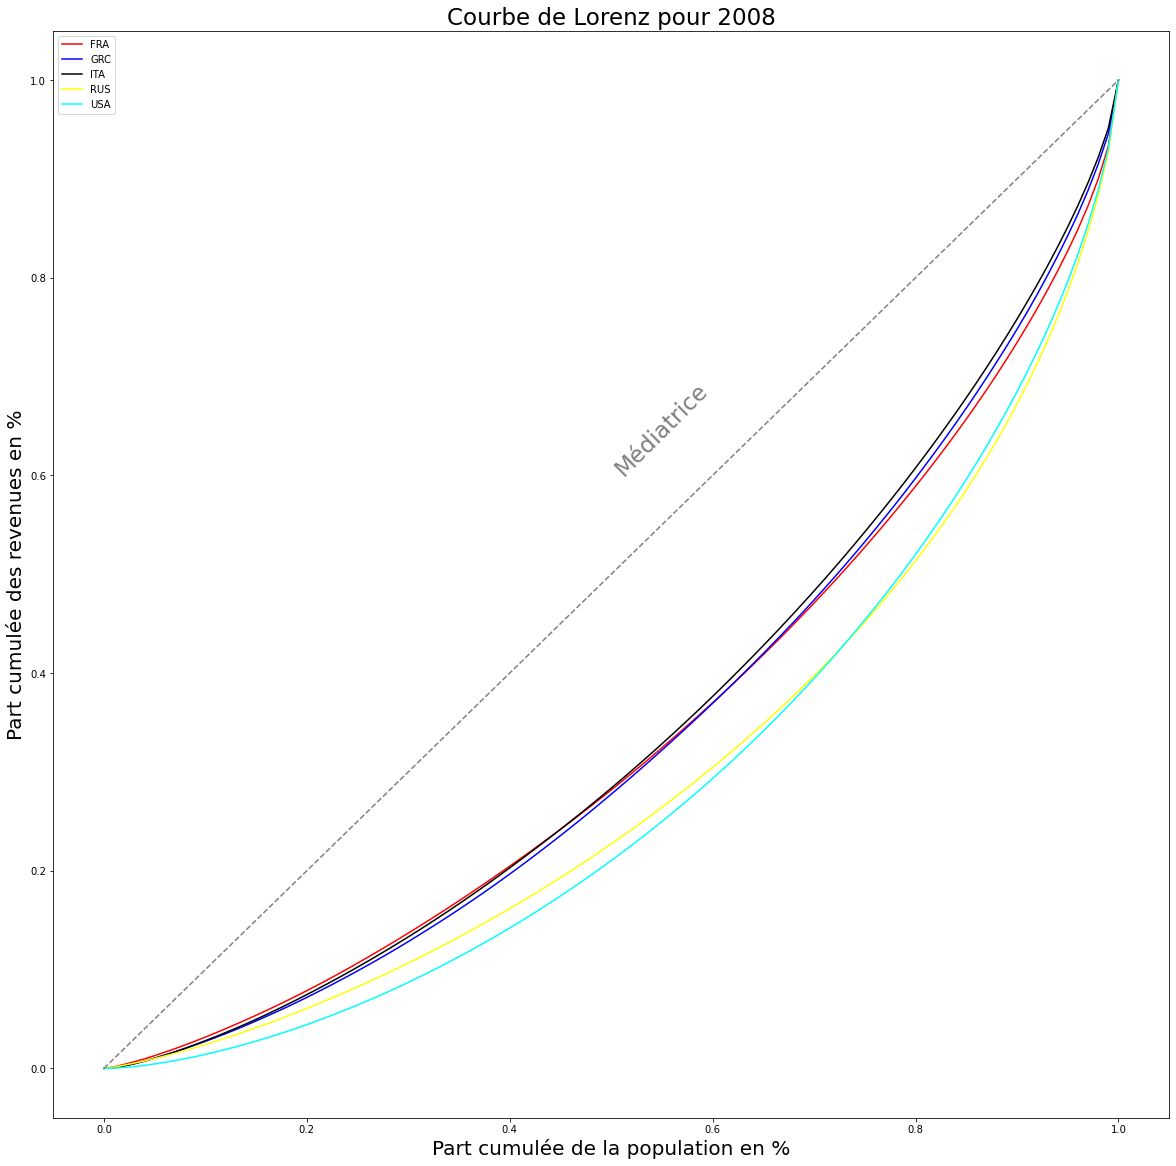

In [322]:
plt.figure(figsize=(20,20))
plt.plot(np.linspace(0,1,len(lorenz_FRA)),lorenz_FRA,color='red')

plt.plot(np.linspace(0,1,len(lorenz_GRC)),lorenz_GRC,color='blue')
plt.plot(np.linspace(0,1,len(lorenz_ITA)),lorenz_ITA,color='black')

plt.plot(np.linspace(0,1,len(lorenz_RUS)),lorenz_RUS,color='yellow')
plt.plot(np.linspace(0,1,len(lorenz_USA)),lorenz_USA,color='cyan')




#médiatrice
x=[0,1]
y=[0,1]
plt.plot(x,y,'gray',linestyle ='--',label='Médiatrice')
plt.text(0.5,0.6,'Médiatrice',color='gray',rotation=45,fontsize=23)

plt.title('Courbe de Lorenz pour 2008',fontsize=23)
plt.ylabel('Part cumulée des revenues en %',fontsize=20)
plt.xlabel('Part cumulée de la population en %',fontsize=20)
plt.legend(labels)

plt.savefig("P7_02_graphics/'Courbe de Lorenz pour 2008'.jpeg")


40 % de la population 10 % - 20 % revenues
80 % de la population 40 % - 50 % revenues

In [323]:
gini_df_selected = gini[gini['Country Code'].isin(['FRA','GRC', 'ITA','RUS','USA'])]


In [324]:
gini_df= gini_df_selected.drop(['Country Name'],axis=1)
gini_df = gini_df.T
#gini_df.rename(columns={"70": "a", "89": "c","116":""})

In [325]:
gini_df.columns = gini_df.iloc[0]
gini_df = gini_df.drop(gini_df.index[0])
gini_df.index.name = 'Year'

In [326]:
gini_df

Country Code,FRA,GRC,ITA,RUS,USA
Year,,,,,
2004,30.6,33.6,34.3,40.3,40.3
2005,29.8,34.6,33.8,41.3,41
2006,29.7,35.1,33.7,41,41.4
2007,32.4,34,32.9,42.3,40.8
2008,33,33.6,33.8,41.6,40.8
2009,32.7,33.6,33.8,39.8,40.6
2010,33.7,34.1,34.7,39.5,40
2011,33.3,34.8,35.1,39.7,40.9


In [327]:
gini_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 2004 to 2011
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   FRA     8 non-null      object
 1   GRC     8 non-null      object
 2   ITA     8 non-null      object
 3   RUS     8 non-null      object
 4   USA     8 non-null      object
dtypes: object(5)
memory usage: 384.0+ bytes


No handles with labels found to put in legend.


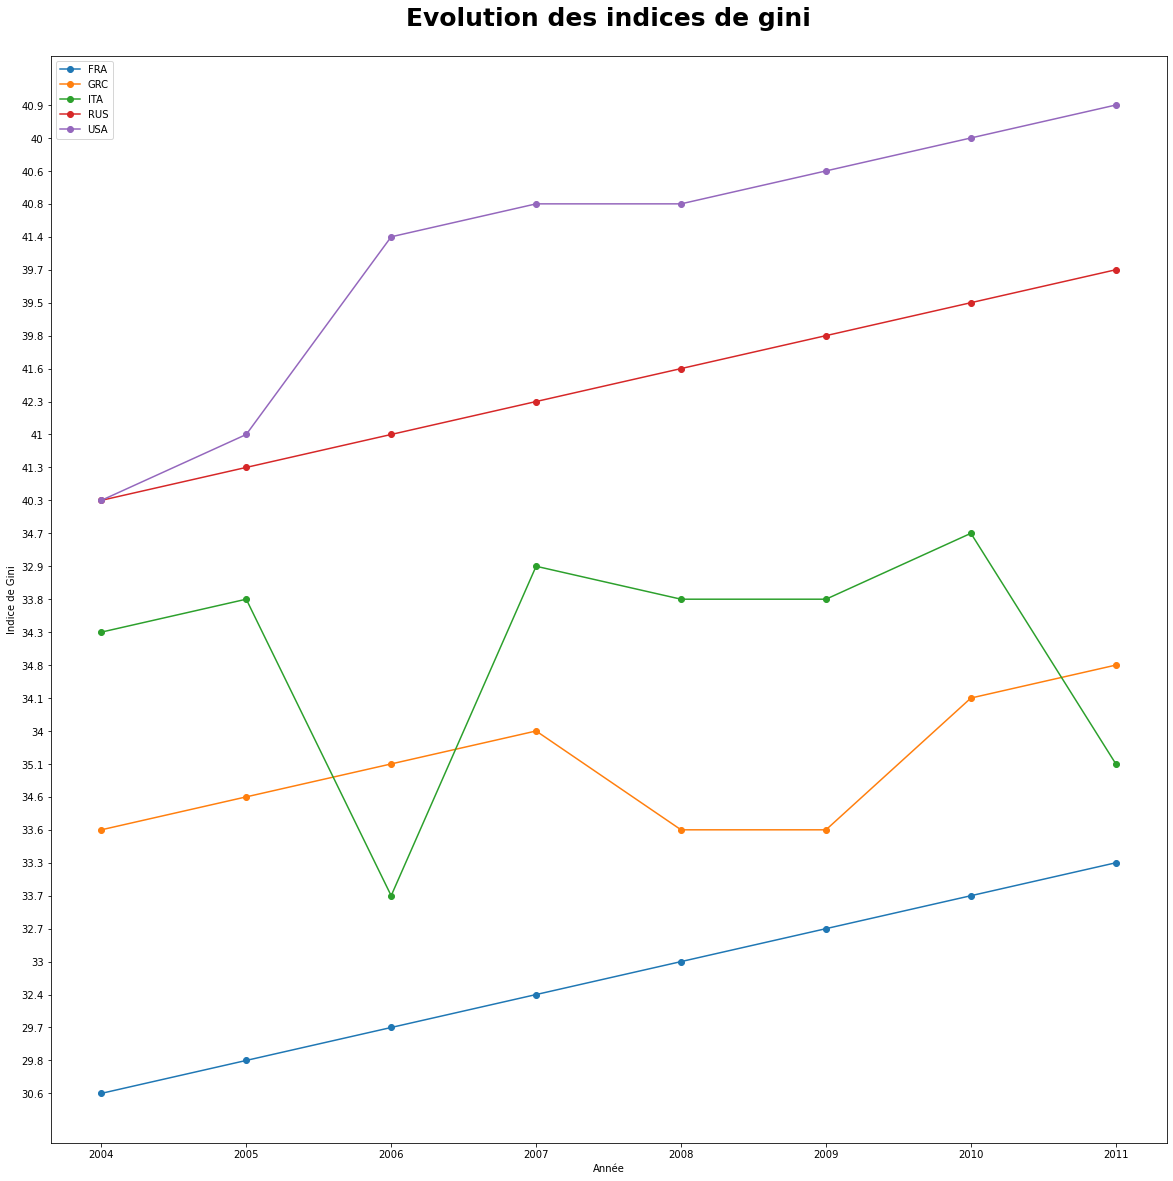

In [328]:
plt.figure(figsize=(20,20))

plt.plot(gini_df['FRA'],'-o')
plt.plot(gini_df['GRC'],'-o')
plt.plot(gini_df['ITA'],'-o')

plt.plot(gini_df['RUS'],'-o')
plt.plot(gini_df['USA'],'-o')
plt.xlabel('Année')
plt.ylabel('Indice de Gini')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 0.5, 0, 0.5))
plt.title('Evolution des indices de gini', pad=30, fontsize = 25, fontweight='bold')

plt.legend(labels)
plt.savefig("P7_02_graphics/'evolution gini'.jpeg")

On observe que le indice de gini pour la France augmente pendante des annees.

In [329]:


gini["2004"] = pd.to_numeric(gini["2004"])
gini["2005"] = pd.to_numeric(gini["2005"])
gini["2006"] = pd.to_numeric(gini["2006"])
gini["2007"] = pd.to_numeric(gini["2007"])
gini["2008"] = pd.to_numeric(gini["2008"])
gini["2009"] = pd.to_numeric(gini["2009"])
gini["2010"] = pd.to_numeric(gini["2010"])
gini["2011"] = pd.to_numeric(gini["2011"])

In [330]:
# Mise en forme des données


gini.drop(columns=['Country Name'], inplace = True)
gini.set_index('Country Code', inplace=True)


gini.tail()


,2004,2005,2006,2007,2008,2009,2010,2011
Country Code,,,,,,,,
XKX,NaN,31.2,30.3,NaN,NaN,31.8,33.3,27.8
YEM,NaN,34.7,NaN,NaN,NaN,NaN,NaN,NaN
ZAF,NaN,64.8,NaN,NaN,63.0,NaN,63.4,NaN
ZMB,54.3,NaN,54.6,NaN,NaN,NaN,55.6,NaN
ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.2


In [331]:
gini.head()

,2004,2005,2006,2007,2008,2009,2010,2011
Country Code,,,,,,,,
ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AFE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AFW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGO,NaN,NaN,NaN,NaN,42.7,NaN,NaN,NaN


In [332]:
# Données disponibles pour la France
gini_fra = gini.loc[gini.index == 'FRA'].iloc[0:].dropna(axis=1)
gini_fra

,2004,2005,2006,2007,2008,2009,2010,2011
Country Code,,,,,,,,
FRA,30.6,29.8,29.7,32.4,33.0,32.7,33.7,33.3


No handles with labels found to put in legend.


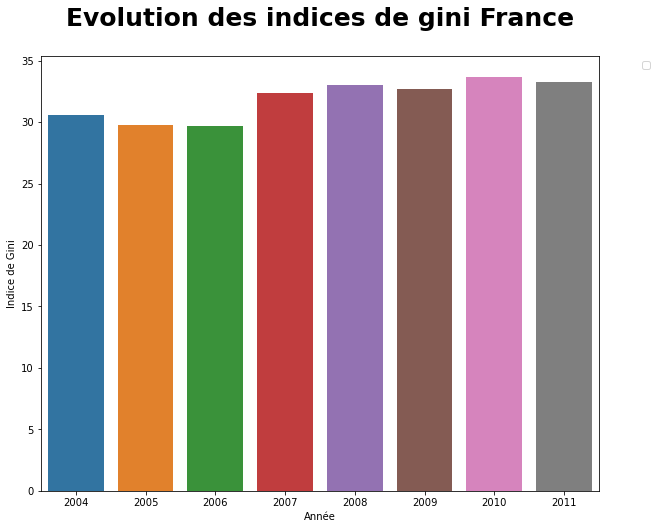

In [333]:
# visualisation de la France


plt.figure(figsize=(10,8))
sns.barplot(data=gini_fra)
plt.xlabel('Année')
plt.ylabel('Indice de Gini')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 0.5, 0, 0.5))
plt.title('Evolution des indices de gini France', pad=30, fontsize = 25, fontweight='bold')

plt.savefig("P7_02_graphics/'evolution gini FRance'.jpeg")
plt.show()

In [334]:
gini.reset_index(inplace=True)

In [335]:
gini

,Country Code,2004,2005,2006,2007,2008,2009,2010,2011
0,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AFW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AGO,NaN,NaN,NaN,NaN,42.7,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
261,XKX,NaN,31.2,30.3,NaN,NaN,31.8,33.3,27.8
262,YEM,NaN,34.7,NaN,NaN,NaN,NaN,NaN,NaN
263,ZAF,NaN,64.8,NaN,NaN,63.0,NaN,63.4,NaN
264,ZMB,54.3,NaN,54.6,NaN,NaN,NaN,55.6,NaN


In [336]:
gini_selected_countries = gini[(gini['Country Code'] == 'FRA') ^ (gini['Country Code'] == 'GRC') ^ (gini['Country Code'] == 'ITA') ^ 
                               (gini['Country Code'] == 'RUS') ^ (gini['Country Code'] == 'USA')]

gini_selected_countries = gini_selected_countries[['Country Code', '2004', '2006', '2007', '2008', '2009', '2010', 
                                               '2011']].sort_values(by='Country Code')

gini_selected_countries

,Country Code,2004,2006,2007,2008,2009,2010,2011
77,FRA,30.6,29.7,32.4,33.0,32.7,33.7,33.3
89,GRC,33.6,35.1,34.0,33.6,33.6,34.1,34.8
116,ITA,34.3,33.7,32.9,33.8,33.8,34.7,35.1
202,RUS,40.3,41.0,42.3,41.6,39.8,39.5,39.7
251,USA,40.3,41.4,40.8,40.8,40.6,40.0,40.9


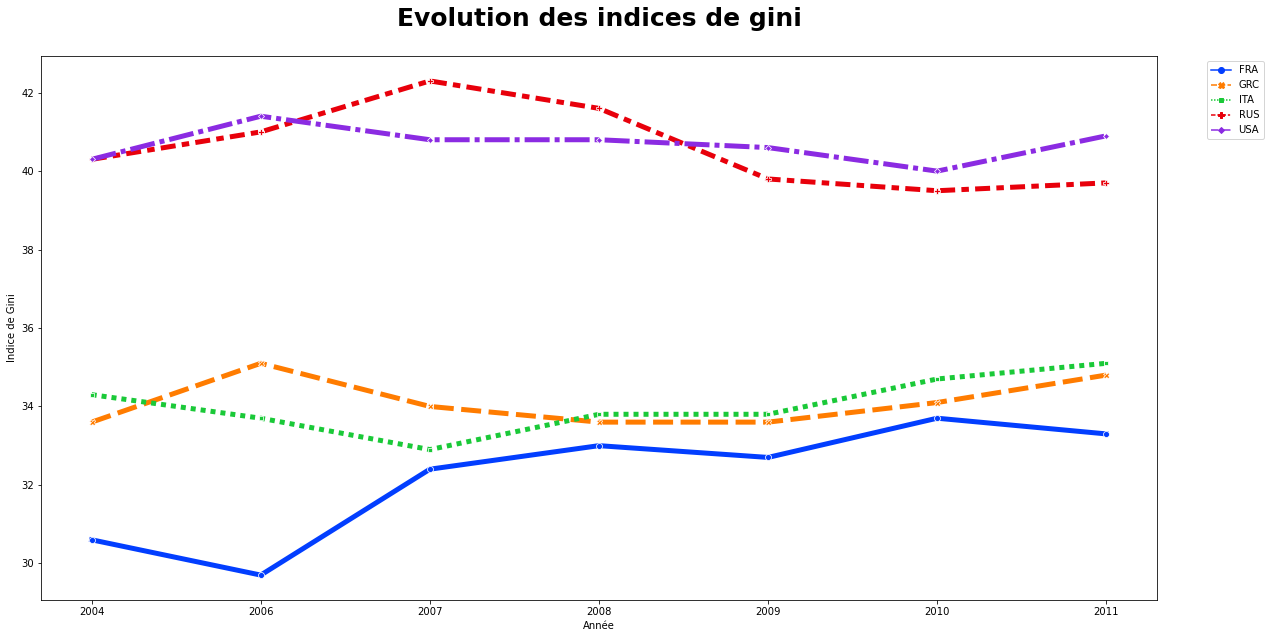

In [337]:
plt.figure(figsize=(20,10))

sns.lineplot(data=gini_selected_countries.set_index('Country Code').T.astype(float), markers=True, linewidth=5,palette='bright')
plt.xlabel('Année')
plt.ylabel('Indice de Gini')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 0.5, 0, 0.5))
plt.title('Evolution des indices de gini', pad=30, fontsize = 25, fontweight='bold')

plt.savefig("P7_02_graphics/'Evolution des indices de gini'.jpeg")    
plt.show()

L'inégalité d'un pays se mesure par la force de son indice de Gini. On peut représenter l'évolution de cette inégalité sur la durée de l'étude. Elle a notamment progressé en France.

## Classement par indice de gini

In [338]:
gini_class = gini
#gini_class= gini_class.drop(['Country Name'],axis=1)
gini_class = gini_class.T

In [339]:
gini_class

,0,1,2,3,4,5,6,7,8,9,...,256,257,258,259,260,261,262,263,264,265
Country Code,ABW,AFE,AFG,AFW,AGO,ALB,AND,ARB,ARE,ARG,...,VIR,VNM,VUT,WLD,WSM,XKX,YEM,ZAF,ZMB,ZWE
2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.4,...,NaN,36.8,NaN,NaN,NaN,NaN,NaN,NaN,54.3,NaN
2005,NaN,NaN,NaN,NaN,NaN,30.6,NaN,NaN,NaN,47.7,...,NaN,NaN,NaN,NaN,NaN,31.2,34.7,64.8,NaN,NaN
2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.3,...,NaN,35.8,NaN,NaN,NaN,30.3,NaN,NaN,54.6,NaN
2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008,NaN,NaN,NaN,NaN,42.7,30.0,NaN,NaN,NaN,44.9,...,NaN,35.6,NaN,NaN,42.0,NaN,NaN,63.0,NaN,NaN
2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.7,...,NaN,NaN,NaN,NaN,NaN,31.8,NaN,NaN,NaN,NaN
2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.6,...,NaN,39.3,37.6,NaN,NaN,33.3,NaN,63.4,55.6,NaN
2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.6,...,NaN,NaN,NaN,NaN,NaN,27.8,NaN,NaN,NaN,43.2


In [340]:
gini_class.columns = gini_class.iloc[0]

In [341]:
gini_class = gini_class.drop(gini_class.index[0])

In [342]:
gini_class

Country Code,ABW,AFE,AFG,AFW,AGO,ALB,AND,ARB,ARE,ARG,...,VIR,VNM,VUT,WLD,WSM,XKX,YEM,ZAF,ZMB,ZWE
2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.4,...,NaN,36.8,NaN,NaN,NaN,NaN,NaN,NaN,54.3,NaN
2005,NaN,NaN,NaN,NaN,NaN,30.6,NaN,NaN,NaN,47.7,...,NaN,NaN,NaN,NaN,NaN,31.2,34.7,64.8,NaN,NaN
2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.3,...,NaN,35.8,NaN,NaN,NaN,30.3,NaN,NaN,54.6,NaN
2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008,NaN,NaN,NaN,NaN,42.7,30.0,NaN,NaN,NaN,44.9,...,NaN,35.6,NaN,NaN,42.0,NaN,NaN,63.0,NaN,NaN
2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.7,...,NaN,NaN,NaN,NaN,NaN,31.8,NaN,NaN,NaN,NaN
2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.6,...,NaN,39.3,37.6,NaN,NaN,33.3,NaN,63.4,55.6,NaN
2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.6,...,NaN,NaN,NaN,NaN,NaN,27.8,NaN,NaN,NaN,43.2


## Classement  par indice de  Gini

In [343]:
gini_df_selected = gini[gini['Country Code'].isin(['FRA', 'GRC','ITA','RUS', 'USA'])]

In [344]:
gini_df_selected

,Country Code,2004,2005,2006,2007,2008,2009,2010,2011
77,FRA,30.6,29.8,29.7,32.4,33.0,32.7,33.7,33.3
89,GRC,33.6,34.6,35.1,34.0,33.6,33.6,34.1,34.8
116,ITA,34.3,33.8,33.7,32.9,33.8,33.8,34.7,35.1
202,RUS,40.3,41.3,41.0,42.3,41.6,39.8,39.5,39.7
251,USA,40.3,41.0,41.4,40.8,40.8,40.6,40.0,40.9


In [345]:
gini_df_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 77 to 251
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Code  5 non-null      object 
 1   2004          5 non-null      float64
 2   2005          5 non-null      float64
 3   2006          5 non-null      float64
 4   2007          5 non-null      float64
 5   2008          5 non-null      float64
 6   2009          5 non-null      float64
 7   2010          5 non-null      float64
 8   2011          5 non-null      float64
dtypes: float64(8), object(1)
memory usage: 400.0+ bytes


In [346]:
gini_df_selected["2004"] = pd.to_numeric(gini_df_selected["2004"])
gini_df_selected["2005"] = pd.to_numeric(gini_df_selected["2005"])
gini_df_selected["2006"] = pd.to_numeric(gini_df_selected["2006"])
gini_df_selected["2007"] = pd.to_numeric(gini_df_selected["2007"])
gini_df_selected["2008"] = pd.to_numeric(gini_df_selected["2008"])
gini_df_selected["2009"] = pd.to_numeric(gini_df_selected["2009"])
gini_df_selected["2010"] = pd.to_numeric(gini_df_selected["2010"])
gini_df_selected["2011"] = pd.to_numeric(gini_df_selected["2011"])

In [347]:
gini_df_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 77 to 251
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Code  5 non-null      object 
 1   2004          5 non-null      float64
 2   2005          5 non-null      float64
 3   2006          5 non-null      float64
 4   2007          5 non-null      float64
 5   2008          5 non-null      float64
 6   2009          5 non-null      float64
 7   2010          5 non-null      float64
 8   2011          5 non-null      float64
dtypes: float64(8), object(1)
memory usage: 400.0+ bytes


In [348]:
gini_df_selected['mean_gini'] = gini_df_selected[['2004','2005','2006','2007','2008','2009','2010','2011']].mean(numeric_only=True, axis=1)






In [349]:
gini_df_selected.sort_values(by='mean_gini',ascending=False)

,Country Code,2004,2005,2006,2007,2008,2009,2010,2011,mean_gini
251,USA,40.3,41.0,41.4,40.8,40.8,40.6,40.0,40.9,40.7250
202,RUS,40.3,41.3,41.0,42.3,41.6,39.8,39.5,39.7,40.6875
89,GRC,33.6,34.6,35.1,34.0,33.6,33.6,34.1,34.8,34.1750
116,ITA,34.3,33.8,33.7,32.9,33.8,33.8,34.7,35.1,34.0125
77,FRA,30.6,29.8,29.7,32.4,33.0,32.7,33.7,33.3,31.9000


In [350]:
print("La moyenne des indices de gini est de :", round(gini_df_selected['mean_gini'].mean(),2))

La moyenne des indices de gini est de : 36.3


In [351]:
print("Position de le France :", gini[gini['Country Code'] == 'FRA'].index[0]+1)
gini[gini['Country Code'] == 'FRA']

Position de le France : 78


,Country Code,2004,2005,2006,2007,2008,2009,2010,2011
77,FRA,30.6,29.8,29.7,32.4,33.0,32.7,33.7,33.3


In [352]:

print("Position de le France :", gini[gini['Country Code'] == 'FRA'].index[0]+1)
gini[gini['Country Code'] == 'FRA']

Position de le France : 78


,Country Code,2004,2005,2006,2007,2008,2009,2010,2011
77,FRA,30.6,29.8,29.7,32.4,33.0,32.7,33.7,33.3


In [353]:
df.drop(['country_name'], axis=1, inplace=True)


In [354]:
df.head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp,gini,Country Name,population
0,ALB,2008,1,100,728.89795,7297.0,0.304624,Albania,2947314
1,ALB,2008,2,100,916.66235,7297.0,0.304624,Albania,2947314
2,ALB,2008,3,100,1010.91600,7297.0,0.304624,Albania,2947314
3,ALB,2008,4,100,1086.90780,7297.0,0.304624,Albania,2947314
4,ALB,2008,5,100,1132.69970,7297.0,0.304624,Albania,2947314


In [355]:
gini_df_selected.rename(columns = {'Country Code':'country'}, inplace = True)
gini_df_selected

,country,2004,2005,2006,2007,2008,2009,2010,2011,mean_gini
77,FRA,30.6,29.8,29.7,32.4,33.0,32.7,33.7,33.3,31.9000
89,GRC,33.6,34.6,35.1,34.0,33.6,33.6,34.1,34.8,34.1750
116,ITA,34.3,33.8,33.7,32.9,33.8,33.8,34.7,35.1,34.0125
202,RUS,40.3,41.3,41.0,42.3,41.6,39.8,39.5,39.7,40.6875
251,USA,40.3,41.0,41.4,40.8,40.8,40.6,40.0,40.9,40.7250


In [356]:
data_gini = gini.copy()

In [357]:
data_gini.drop(['2005'],axis=1, inplace=True)

In [358]:
data_gini.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Code  266 non-null    object 
 1   2004          70 non-null     float64
 2   2006          75 non-null     float64
 3   2007          70 non-null     float64
 4   2008          73 non-null     float64
 5   2009          78 non-null     float64
 6   2010          83 non-null     float64
 7   2011          77 non-null     float64
dtypes: float64(7), object(1)
memory usage: 16.8+ KB


In [359]:
data_gini['mean'] = data_gini.mean(axis=1)
data_gini

,Country Code,2004,2006,2007,2008,2009,2010,2011,mean
0,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AFW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AGO,NaN,NaN,NaN,42.7,NaN,NaN,NaN,42.700000
...,...,...,...,...,...,...,...,...,...
261,XKX,NaN,30.3,NaN,NaN,31.8,33.3,27.8,30.800000
262,YEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,ZAF,NaN,NaN,NaN,63.0,NaN,63.4,NaN,63.200000
264,ZMB,54.3,54.6,NaN,NaN,NaN,55.6,NaN,54.833333


In [360]:
data_gini.drop(['2004','2006','2007','2008','2009','2010','2011'],axis=1, inplace=True)


In [361]:
data_gini.rename(columns = {'Country Code':'country'}, inplace = True)
data_gini.dropna(inplace=True)

In [362]:
data_gini.sort_values(by="mean")

,country,mean
222,SVN,24.557143
58,DNK,26.200000
221,SVK,26.371429
54,CZE,26.528571
15,AZE,26.600000
...,...,...
46,COM,55.900000
34,CAF,56.200000
33,BWA,60.500000
171,NAM,61.000000


Les 5 pays les plus égalitaires (indice de Gini le plus faible).
Les 5 pays les plus inégalitaires (indice de Gini le plus fort).

# Mission 3

Dans l'état actuel, nous avons à disposition deux des trois variables explicatives souhaitées :

\(m_{j}\) le revenu moyen du pays  \(j\)

\(G_{j}\) l'indice de Gini du pays \(j\)

Il nous manque donc, pour un individu  \(i\) , la classe de revenu \(c_{i,parent}\) de ses parents.

Nous supposons ici que l'on associe à chaque individu \(i\) une unique classe \(c_{i,parent}\) ; quel que soit le nombre de parents de \(i\).

Nous allons donc simuler cette information grâce à un coefficient \(\rho_{j}\) (propre à chaque pays \(j\) ), mesurant une corrélation entre le revenu de l'individu \(i\) et le revenu de ses parents. Ce coefficient sera ici appelé coefficient d'élasticité ; il mesure la mobilité intergénérationnelle du revenu.

Pour plus d'informations sur le calcul du coefficient d'élasticité, consulter ce document, notamment l'équation 1 de la page 8. Ce coefficient est déterminé par une régression linéaire simple dans laquelle le logarithme du revenu de l'enfant \(Y_{child}\) est une fonction du logarithme du revenu des parents \(Y_{parent}\) :

\[ln(Y_{child}) = \alpha + \rho_j\ ln(Y_{parent}) + \epsilon\]

Pour obtenir le coefficient d'élasticité, deux possibilités s'offrent à vous :

Vous baser sur ces coefficients donnés par la Banque mondiale, dans GDIM dataset. Le coefficient d'élasticité est donné pour certains pays, sous le nom d'IGE Income (relative IGM in income).
Vous baser sur des estimations provenant de multiples études, extrapolées à différentes régions du monde :  elles se trouvent dans le fichier elasticity.txt. Attention, ces données sont parfois anciennes.
Il est aussi possible de combiner ces deux approches.

Pour chaque pays, nous allons utiliser une génération aléatoire de la classe de revenu des parents, à partir de ces seules deux informations :

\(\rho_j\)
la classe de revenu de l'enfant  \(c_{i,child}\).
Attention à bien utiliser la classe de revenu de l'enfant (qui est un nombre compris entre 1 et 100 si vous utilisez 100 quantiles), plutôt que son revenu PPP. De même, on ne cherche pas à générer le revenu des parents, mais la classe de revenu des parents \(c_{i,parent}\).



$$\ln(Y_{child}) = \alpha + \rho_j\ ln(Y_{parent}) + \epsilon\$$

# Coefficient d'élasticité

Cette valeur servira au calcul des probabilités.

In [363]:
import scipy.stats as st

import statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [364]:
path = '../P7_Zaklina_Bozovic/donnees/'
gdim = pd.read_csv(path +'GDIMMay2018.csv')

In [365]:
gdim.head()

,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,...,Cores2125_MAcatC1,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu
0,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25103.0,0.086197,18054.0,0.345224,NaN,NaN,NaN,NaN,0.1
1,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12107.0,0.083271,8538.0,0.389952,NaN,NaN,NaN,NaN,0.1
2,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12996.0,0.089161,9516.0,0.307687,NaN,NaN,NaN,NaN,0.1
3,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25396.0,0.050447,18387.0,0.218062,NaN,NaN,NaN,NaN,0.1
4,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12246.0,0.047961,8677.0,0.230909,NaN,NaN,NaN,NaN,0.1


In [366]:
gdim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6504 entries, 0 to 6503
Data columns (total 66 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   countryname        6504 non-null   object 
 1   wbcode             6504 non-null   object 
 2   iso3               6504 non-null   object 
 3   region             6504 non-null   object 
 4   incgroup2          6504 non-null   object 
 5   incgroup4          6504 non-null   object 
 6   fragile            6504 non-null   int64  
 7   survey             6501 non-null   object 
 8   year               6504 non-null   int64  
 9   status             6501 non-null   object 
 10  cohort             6504 non-null   int64  
 11  parent             6504 non-null   object 
 12  child              6504 non-null   object 
 13  obs                6501 non-null   float64
 14  P1                 6501 non-null   float64
 15  P2                 6501 non-null   float64
 16  P3                 6501 

Le coefficient se trouve dans la variable IGEincome. On garde cette variable et region.

In [367]:
gdim = gdim.pivot_table(
    index=['iso3', 'region'], values='IGEincome').reset_index().rename(
    columns={'iso3': 'country', 'IGEincome': 'IGE'})
gdim

,country,region,IGE
0,ALB,Europe & Central Asia,0.815874
1,AUS,High income,0.275000
2,AUT,High income,0.245267
3,BEL,High income,0.183176
4,BEN,Sub-Saharan Africa,0.855116
...,...,...,...
70,UGA,Sub-Saharan Africa,1.029195
71,USA,High income,0.537666
72,UZB,Europe & Central Asia,0.496764
73,VNM,East Asia & Pacific,0.480000


In [368]:
df = df.merge(gdim, on='country', how='left')
df

,country,year_survey,quantile,nb_quantiles,income,gdpppp,gini,Country Name,population,region,IGE
0,ALB,2008,1,100,728.89795,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874
1,ALB,2008,2,100,916.66235,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874
2,ALB,2008,3,100,1010.91600,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874
3,ALB,2008,4,100,1086.90780,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874
4,ALB,2008,5,100,1132.69970,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874
...,...,...,...,...,...,...,...,...,...,...,...
11595,COD,2008,97,100,911.78340,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703
11596,COD,2008,98,100,1057.80740,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703
11597,COD,2008,99,100,1286.60290,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703
11598,COD,2008,100,100,2243.12260,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703


In [369]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11600 entries, 0 to 11599
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       11600 non-null  object 
 1   year_survey   11600 non-null  int64  
 2   quantile      11600 non-null  int64  
 3   nb_quantiles  11600 non-null  int64  
 4   income        11600 non-null  float64
 5   gdpppp        11600 non-null  float64
 6   gini          11600 non-null  float64
 7   Country Name  11500 non-null  object 
 8   population    11600 non-null  int32  
 9   region        6600 non-null   object 
 10  IGE           6600 non-null   float64
dtypes: float64(4), int32(1), int64(3), object(3)
memory usage: 1.0+ MB


Après jointure, 48 pays n'ont pas de coefficient d'élasticité. Cette variable étant nécessaire à la génération de la classe parents, on écarte toutes les valeurs manquantes

In [370]:
df.dropna(inplace=True)
df

,country,year_survey,quantile,nb_quantiles,income,gdpppp,gini,Country Name,population,region,IGE
0,ALB,2008,1,100,728.89795,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874
1,ALB,2008,2,100,916.66235,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874
2,ALB,2008,3,100,1010.91600,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874
3,ALB,2008,4,100,1086.90780,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874
4,ALB,2008,5,100,1132.69970,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874
...,...,...,...,...,...,...,...,...,...,...,...
11594,COD,2008,96,100,810.62330,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703
11595,COD,2008,97,100,911.78340,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703
11596,COD,2008,98,100,1057.80740,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703
11597,COD,2008,99,100,1286.60290,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703


In [371]:
df.describe()

,year_survey,quantile,nb_quantiles,income,gdpppp,gini,population,IGE
count,6500.000000,6500.000000,6500.0,6500.000000,6500.000000,6500.000000,6.500000e+03,6500.000000
mean,2008.107692,50.500000,100.0,14026.285779,16055.029186,0.556738,7.708960e+07,0.523642
std,0.913611,28.868291,0.0,64873.988257,15299.455895,0.286473,2.166431e+08,0.244744
min,2006.000000,1.000000,100.0,16.719418,303.193050,0.230731,4.886500e+05,0.112876
25%,2008.000000,25.750000,100.0,1065.536275,2796.000000,0.304624,5.493621e+06,0.342000
50%,2008.000000,50.500000,100.0,3800.581050,10469.000000,0.407193,1.644559e+07,0.480000
75%,2008.000000,75.250000,100.0,11902.574000,28170.000000,0.924520,4.977947e+07,0.677000
max,2011.000000,100.000000,100.0,964233.000000,73127.000000,0.970366,1.317885e+09,1.095440


In [372]:
pivot = df.pivot_table(index=['Country Name', 'country', 'region']).reset_index().rename(columns={'income': 'income_mean'})
pivot

,Country Name,country,region,IGE,gdpppp,gini,income_mean,nb_quantiles,population,quantile,year_survey
0,Albania,ALB,Europe & Central Asia,0.815875,7297.0000,0.304624,2994.829902,100,2947314,50.5,2008
1,Austria,AUT,High income,0.245267,36193.0000,0.278279,16637.600204,100,8321496,50.5,2008
2,Bangladesh,BGD,South Asia,0.538000,1233.0000,0.940881,32944.164959,100,147575433,50.5,2010
3,Belarus,BLR,Europe & Central Asia,0.342738,11651.0000,0.266125,3921.163534,100,9527985,50.5,2008
4,Belgium,BEL,High income,0.183176,33561.0000,0.284595,15024.614176,100,10709973,50.5,2008
...,...,...,...,...,...,...,...,...,...,...,...
60,Timor-Leste,TLS,East Asia & Pacific,0.701994,1113.1322,0.938177,35653.519525,100,1036388,50.5,2007
61,Uganda,UGA,Sub-Saharan Africa,1.029195,1067.0000,0.936802,28956.758739,100,31411096,50.5,2009
62,United Kingdom,GBR,High income,0.480978,34048.0000,0.339382,21709.604470,100,61806995,50.5,2008
63,United States,USA,High income,0.537666,43261.0000,0.431799,25503.581661,100,304093966,50.5,2008


In [373]:
print(len(pivot['country'].unique()), 'pays répartis en',
    len(pivot['region'].unique()), 'régions :\n\n')

for i in pivot['region'].unique():
    print(i, ':',
        pivot[pivot['region']==i]['Country Name'].unique(), '\n')

65 pays répartis en 7 régions :


Europe & Central Asia : ['Albania' 'Belarus' 'Bosnia and Herzegovina' 'Kazakhstan'
 'Kyrgyz Republic' 'North Macedonia' 'Romania' 'Russian Federation'] 

High income : ['Austria' 'Belgium' 'Canada' 'Chile' 'Croatia' 'Cyprus' 'Czech Republic'
 'Denmark' 'Finland' 'France' 'Germany' 'Greece' 'Ireland' 'Italy' 'Japan'
 'Korea, Rep.' 'Latvia' 'Luxembourg' 'Netherlands' 'Norway' 'Portugal'
 'Slovak Republic' 'Slovenia' 'Spain' 'Sweden' 'United Kingdom'
 'United States'] 

South Asia : ['Bangladesh' 'India' 'Nepal' 'Pakistan'] 

Latin America & Caribbean : ['Bolivia' 'Brazil' 'Colombia' 'Ecuador' 'Guatemala' 'Panama' 'Peru'] 

East Asia & Pacific : ['China' 'Malaysia' 'Mongolia' 'Timor-Leste' 'Vietnam'] 

Sub-Saharan Africa : ['Congo, Dem. Rep.' 'Ghana' 'Guinea' 'Kenya' 'Madagascar' 'Malawi' 'Mali'
 'Nigeria' 'South Africa' 'Tanzania' 'Uganda'] 

Middle East & North Africa : ['Egypt, Arab Rep.' 'Jordan' 'Morocco'] 



In [374]:
df = df.merge(pivot[['country', 'income_mean']], on='country', how='left')

In [375]:
df

,country,year_survey,quantile,nb_quantiles,income,gdpppp,gini,Country Name,population,region,IGE,income_mean
0,ALB,2008,1,100,728.89795,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902
1,ALB,2008,2,100,916.66235,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902
2,ALB,2008,3,100,1010.91600,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902
3,ALB,2008,4,100,1086.90780,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902
4,ALB,2008,5,100,1132.69970,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,COD,2008,96,100,810.62330,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324
6496,COD,2008,97,100,911.78340,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324
6497,COD,2008,98,100,1057.80740,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324
6498,COD,2008,99,100,1286.60290,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324


In [376]:
import scipy.stats as st
import pandas as pd
import numpy as np
from collections import Counter

# Question 1à 6



# Génération de la classe parent

On génére un grand nombre de réalisations d'une variable qu'on appelera selon une loi normale. Le choix de la moyenne et de l'écart-type n'ont pas d'incidence sur le résultat final (sur le calcul de la classe de revenus).

In [377]:
def generate_incomes(n, pj):
    # On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
    ln_y_parent = st.norm(0,1).rvs(size=n)
    # Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)

In [378]:
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])


In [379]:
def compute_quantiles(y_child, y_parents, nb_quantiles):

    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

In [380]:
def distribution(counts, nb_quantiles):
        
    distrib = []
     # On compte le nombre totale d'individus
    total = counts["counts"].sum()
    
    # S'il n'y a aucun individus, une ligne de 0 est renvoyée
    if total == 0 :
        return [0] * nb_quantiles
    
     # Pour chaque quantiles parents
    
    for q_p in range(1, nb_quantiles+1):
        # On ne garde que les lignes du quantile parent concerné
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            # Si la longueur n'est pas nulle, on ajoute au resultat la fréquence d'apparition de q_p
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   


In [381]:
def conditional_distributions(sample, nb_quantiles):
    

     # On compte le nombre d'individus (parents / enfant)  qu'il y a pour chaque paire de quantiles parents / enfant
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    # Enumeration des numeros des quantiles
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 


In [382]:
def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure()
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend()
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")
    plt.savefig("P7_02_graphics/'Distributions Conditionnelles'.jpeg")
    plt.show()

In [383]:
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]

## pj=0.9

In [384]:
## Calcul de proba conditionnelles
pj = 0.9                 # coefficient d'élasticité du pays j
nb_quantiles = 10       # nombre de quantiles (nombre de classes de revenu)
n  = 1000*nb_quantiles   # taille de l'échantillon

alpha =0

# Génération d'une loi normale (ln(yparent) et erreurs)
ln_y_parent = st.norm(0,1).rvs(size=n)
erreurs = st.norm(0,1).rvs(size=n)

#Calcul de ychild
#Pour une valeur donnée de pj (par exemple 0.9), on calcule ychild. 
#Le choix de a n'a aucune incidence sur le résultat final et peut être supprimé. 
#A ce stade, ychild contient des valeurs dont l'ordre de grandeur ne reflète pas la réalité, mais cela n'a pas d'influence pour la suite.


y_child = np.exp(alpha+pj*ln_y_parent+erreurs)
y_parents = np.exp(ln_y_parent)

#calcul de classe de revenus des enfants et des parents
c_i_child = quantiles(pd.Series(y_child), nb_quantiles)
c_i_parent = quantiles(pd.Series(y_parents), nb_quantiles)

child_parent = pd.DataFrame()
child_parent['y_child']=y_child
child_parent['c_i_child']=c_i_child
child_parent['y_parents']=y_parents
child_parent['c_i_parent']=c_i_parent

10000 observations :

 [-0.91819874  0.00781809 -0.17848928 ...  0.70396623 -0.36561451
  1.24453614]


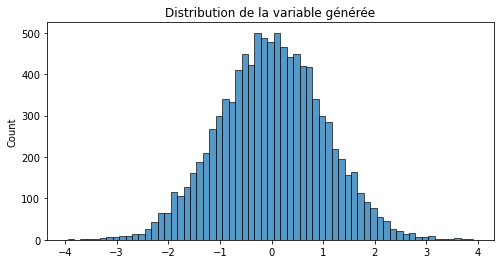

In [385]:
def visu_realisations(data):
    print(len(data), 'observations :\n\n', data)
    plt.figure(figsize=(8, 4))
    sns.histplot(data)
    plt.title('Distribution de la variable générée')
    plt.savefig("P7_02_graphics/'Distribution de la variable générée'.jpeg")  
    plt.show()
    
visu_realisations(ln_y_parent)


On génère maintenant les résidus (le terme d'erreur epsilon) selon une loi normale de moyenne 0 et d'écart-type 1.

10000 observations :

 [-0.12153415  0.9148594  -1.44900478 ...  0.86020122  1.06826469
 -1.10028996]


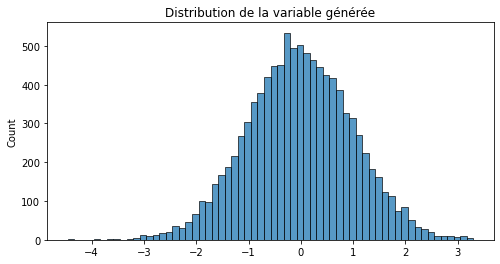

In [386]:
residus = st.norm(0,1).rvs(size=n)
visu_realisations(residus)

10000 observations :

 [0.15806169 0.63873104 1.36183014 ... 3.09496374 1.87947411 2.27831858]


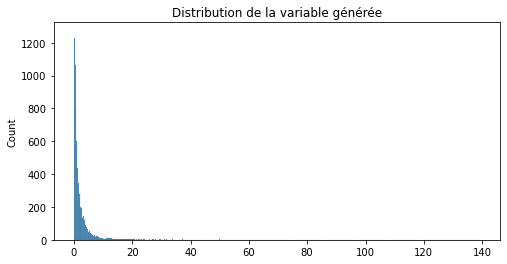

In [387]:
visu_realisations(y_child)

10000 observations :

 [0.39923752 1.00784874 0.83653302 ... 2.02175557 0.69377019 3.47132421]


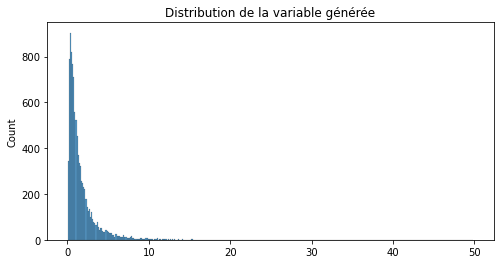

In [388]:
visu_realisations(y_parents)

# Calcul de la classe de revenus des enfants
Pour chacun des individus générés, on calcule maintenant la classe de revenu c_i_child ainsi que la classe de revenu de ses parents , à partir de ychild et yparent.

In [389]:
child_parent

,y_child,c_i_child,y_parents,c_i_parent
0,0.158062,1,0.399238,2
1,0.638731,4,1.007849,6
2,1.361830,6,0.836533,5
3,0.306928,2,0.292392,2
4,0.963966,5,1.056314,6
...,...,...,...,...
9995,0.739420,5,1.666380,7
9996,0.771551,5,1.153865,6
9997,3.094964,9,2.021756,8
9998,1.879474,7,0.693770,4


# Représentations des distributions conditionnelles
Pour vérifier la cohérence du code, on crée un graphique représentant ces distributions conditionnelles. Voici 2 exemples pour une population segmentée en 10 classes, d'abord avec une forte mobilité (0.1) :

In [390]:
#combinaison c_i_child et c_i_parent
counts = child_parent.groupby(["c_i_child","c_i_parent"]).apply(len)
counts = counts.reset_index()
counts.columns = ["c_i_child","c_i_parent","counts"]

In [391]:
distrib = distribution(counts, nb_quantiles)

In [392]:
cond_dist = conditional_distributions(child_parent, nb_quantiles)

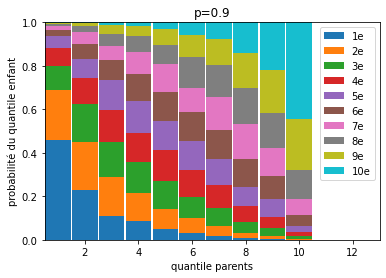

In [393]:
#faible mobilité
plot_conditional_distributions(0.9, cond_dist, nb_quantiles)

# Indice d'élasticité fort == faible mobilité car, par exemple, pour le 1er quantile parent, il y a plus de 40% de 
# chance pour que le quantile enfant soit également 1. 

## pj=0.1

In [394]:
## Calcul de proba conditionnelles
pj = 0.1                 # coefficient d'élasticité du pays j
nb_quantiles = 10       # nombre de quantiles (nombre de classes de revenu)
n  = 1000*nb_quantiles   # taille de l'échantillon

alpha =0

# Génération d'une loi normale (ln(yparent) et erreurs)
ln_y_parent = st.norm(0,1).rvs(size=n)
erreurs = st.norm(0,1).rvs(size=n)

#Calcul de ychild
y_child = np.exp(alpha+pj*ln_y_parent+erreurs)
y_parents = np.exp(ln_y_parent)

#calcul de classe de revenus des enfants et des parents
c_i_child = quantiles(pd.Series(y_child), nb_quantiles)
c_i_parent = quantiles(pd.Series(y_parents), nb_quantiles)

child_parent = pd.DataFrame()
child_parent['y_child']=y_child
child_parent['c_i_child']=c_i_child
child_parent['y_parents']=y_parents
child_parent['c_i_parent']=c_i_parent

In [395]:
#combinaison c_i_child et c_i_parent
counts = child_parent.groupby(["c_i_child","c_i_parent"]).apply(len)
counts = counts.reset_index()
counts.columns = ["c_i_child","c_i_parent","counts"]

In [396]:
distrib = distribution(counts, nb_quantiles)

In [397]:
cond_dist = conditional_distributions(child_parent, nb_quantiles)

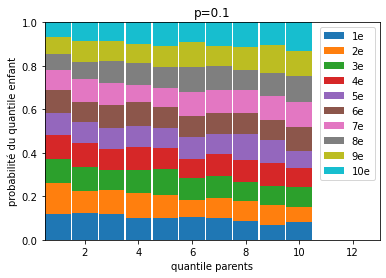

In [398]:
#forte mobilité
plot_conditional_distributions(pj, cond_dist, nb_quantiles)

In [399]:
c_i_child = 1
c_i_parent = 1
p = proba_cond(c_i_parent, c_i_child, cond_dist)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child,
pj, p))


P(c_i_parent = 1 | c_i_child = 1, pj = 0.1) = 0.102


In [400]:
c_i_child = 1
c_i_parent = 9
p = proba_cond(c_i_parent, c_i_child, cond_dist)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child,
pj, p))


P(c_i_parent = 9 | c_i_child = 1, pj = 0.1) = 0.066


# Question 7
Éventuellement et pour éviter toute confusion, effacez les individus que vous venez de générer (nous n'en avons plus besoin), et ne gardez que les distributions conditionnelles.

In [401]:
#del y_parents, y_child

## Question 8

# Nouvel échantillon
On va maintenant travailler sur un nouvel échantillon. Celui-ci sera créé à partir des données principales. Pour chaque individu dans le dataset, on en crée 499 "clones". La taille du nouvel échantillon sera donc 500 fois plus grand que celui d'origine.

On obtient plus de 3 millions d'individus.

In [402]:
sample = pd.concat([df]*500).reset_index().drop('index', axis=1)
sample

,country,year_survey,quantile,nb_quantiles,income,gdpppp,gini,Country Name,population,region,IGE,income_mean
0,ALB,2008,1,100,728.89795,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902
1,ALB,2008,2,100,916.66235,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902
2,ALB,2008,3,100,1010.91600,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902
3,ALB,2008,4,100,1086.90780,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902
4,ALB,2008,5,100,1132.69970,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902
...,...,...,...,...,...,...,...,...,...,...,...,...
3249995,COD,2008,96,100,810.62330,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324
3249996,COD,2008,97,100,911.78340,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324
3249997,COD,2008,98,100,1057.80740,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324
3249998,COD,2008,99,100,1286.60290,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324


# Attribution des classes des parents
Pour chaque c_i_child et chaque pays, il y a maintenant 500 individus. On attribue aux 500 individus leurs classes c_i_parent conformément aux distributions trouvées précédemment. Par exemple, si P(ci,parent = 8|ci,child = 5, pj = 0.9) = 0.03, alors vous assignerez la classe ciparent=8 à 15 des 500 individus du pays ayant cichild=5, car 500*0.03 = 15.

In [403]:
nb_quantiles = 100       # nombre de quantiles (nombre de classes de revenu)
n  = len(sample) # taille de l'échantillon
ln_y_parent = st.norm(0,1).rvs(size=n)
residus = st.norm(0,1).rvs(size=n)

In [404]:
sample = pd.concat([
    pd.DataFrame(list(zip(ln_y_parent, residus)), columns=['ln_y_parent','residus']), 
    sample], axis=1)
sample

,ln_y_parent,residus,country,year_survey,quantile,nb_quantiles,income,gdpppp,gini,Country Name,population,region,IGE,income_mean
0,-1.079511,-0.353795,ALB,2008,1,100,728.89795,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902
1,-0.609005,0.451002,ALB,2008,2,100,916.66235,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902
2,1.368129,-1.505979,ALB,2008,3,100,1010.91600,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902
3,0.366592,1.512701,ALB,2008,4,100,1086.90780,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902
4,-1.123069,2.503391,ALB,2008,5,100,1132.69970,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3249995,0.752790,-2.406369,COD,2008,96,100,810.62330,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324
3249996,-1.123282,0.342858,COD,2008,97,100,911.78340,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324
3249997,-1.286685,-1.083400,COD,2008,98,100,1057.80740,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324
3249998,0.684202,-1.113061,COD,2008,99,100,1286.60290,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324


In [405]:
def generate_y_child(n, pj):
    return np.exp(pj * ln_y_parent + residus)

def generate_y_parents(n, pj):
    return np.exp(ln_y_parent)

sample['y_child'] = 0
sample['y_child'] = generate_y_child(n, sample['IGE'])
sample['y_parents'] = 0
sample['y_parents'] = generate_y_parents(n, sample['IGE'])
sample

,ln_y_parent,residus,country,year_survey,quantile,nb_quantiles,income,gdpppp,gini,Country Name,population,region,IGE,income_mean,y_child,y_parents
0,-1.079511,-0.353795,ALB,2008,1,100,728.89795,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,0.290969,0.339762
1,-0.609005,0.451002,ALB,2008,2,100,916.66235,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,0.955166,0.543892
2,1.368129,-1.505979,ALB,2008,3,100,1010.91600,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,0.677221,3.927994
3,0.366592,1.512701,ALB,2008,4,100,1086.90780,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,6.121422,1.442809
4,-1.123069,2.503391,ALB,2008,5,100,1132.69970,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,4.889588,0.325280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3249995,0.752790,-2.406369,COD,2008,96,100,810.62330,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324,0.153567,2.122915
3249996,-1.123282,0.342858,COD,2008,97,100,911.78340,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324,0.636296,0.325211
3249997,-1.286685,-1.083400,COD,2008,98,100,1057.80740,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324,0.136151,0.276185
3249998,0.684202,-1.113061,COD,2008,99,100,1286.60290,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324,0.533205,1.982189


On classe les c_i_child et c_i_parent par centile.

In [406]:
sample['c_i_child'] = pd.qcut(sample['y_child'], 100, labels=False) + 1
sample['c_i_parent'] = pd.qcut(sample['y_parents'], 100, labels=False) + 1
sample

,ln_y_parent,residus,country,year_survey,quantile,nb_quantiles,income,gdpppp,gini,Country Name,population,region,IGE,income_mean,y_child,y_parents,c_i_child,c_i_parent
0,-1.079511,-0.353795,ALB,2008,1,100,728.89795,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,0.290969,0.339762,14,14
1,-0.609005,0.451002,ALB,2008,2,100,916.66235,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,0.955166,0.543892,49,28
2,1.368129,-1.505979,ALB,2008,3,100,1010.91600,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,0.677221,3.927994,37,92
3,0.366592,1.512701,ALB,2008,4,100,1086.90780,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,6.121422,1.442809,95,65
4,-1.123069,2.503391,ALB,2008,5,100,1132.69970,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,4.889588,0.325280,92,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3249995,0.752790,-2.406369,COD,2008,96,100,810.62330,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324,0.153567,2.122915,6,78
3249996,-1.123282,0.342858,COD,2008,97,100,911.78340,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324,0.636296,0.325211,35,14
3249997,-1.286685,-1.083400,COD,2008,98,100,1057.80740,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324,0.136151,0.276185,5,10
3249998,0.684202,-1.113061,COD,2008,99,100,1286.60290,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324,0.533205,1.982189,29,76


In [407]:
len(sorted(sample['c_i_child'].unique()))

100

Pour éviter toute confusion, on efface la variable c_i_child, inutile pour la suite.

In [408]:
sample.drop(['c_i_child', 'y_child', 'y_parents','ln_y_parent','residus'], axis=1, inplace=True)
sample

,country,year_survey,quantile,nb_quantiles,income,gdpppp,gini,Country Name,population,region,IGE,income_mean,c_i_parent
0,ALB,2008,1,100,728.89795,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,14
1,ALB,2008,2,100,916.66235,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,28
2,ALB,2008,3,100,1010.91600,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,92
3,ALB,2008,4,100,1086.90780,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,65
4,ALB,2008,5,100,1132.69970,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3249995,COD,2008,96,100,810.62330,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324,78
3249996,COD,2008,97,100,911.78340,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324,14
3249997,COD,2008,98,100,1057.80740,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324,10
3249998,COD,2008,99,100,1286.60290,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324,76


In [409]:
data_gini['gini']=data_gini['mean']

In [410]:
data_gini

,country,mean,gini
4,AGO,42.700000,42.700000
5,ALB,30.000000,30.000000
9,ARG,45.100000,45.100000
10,ARM,30.714286,30.714286
13,AUS,34.400000,34.400000
...,...,...,...
260,WSM,42.000000,42.000000
261,XKX,30.800000,30.800000
263,ZAF,63.200000,63.200000
264,ZMB,54.833333,54.833333


In [411]:
sample = pd.merge(sample, data_gini, how='left', left_on='country',right_on='country')

In [412]:
sample

,country,year_survey,quantile,nb_quantiles,income,gdpppp,gini_x,Country Name,population,region,IGE,income_mean,c_i_parent,mean,gini_y
0,ALB,2008,1,100,728.89795,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,14,30.0,30.0
1,ALB,2008,2,100,916.66235,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,28,30.0,30.0
2,ALB,2008,3,100,1010.91600,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,92,30.0,30.0
3,ALB,2008,4,100,1086.90780,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,65,30.0,30.0
4,ALB,2008,5,100,1132.69970,7297.00000,0.304624,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,14,30.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3249995,COD,2008,96,100,810.62330,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324,78,42.2,42.2
3249996,COD,2008,97,100,911.78340,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324,14,42.2,42.2
3249997,COD,2008,98,100,1057.80740,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324,10,42.2,42.2
3249998,COD,2008,99,100,1286.60290,303.19305,0.970366,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324,76,42.2,42.2


In [413]:
sample = sample.drop(['gini_x','mean'],axis=1)

In [414]:
sample

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,region,IGE,income_mean,c_i_parent,gini_y
0,ALB,2008,1,100,728.89795,7297.00000,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,14,30.0
1,ALB,2008,2,100,916.66235,7297.00000,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,28,30.0
2,ALB,2008,3,100,1010.91600,7297.00000,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,92,30.0
3,ALB,2008,4,100,1086.90780,7297.00000,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,65,30.0
4,ALB,2008,5,100,1132.69970,7297.00000,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,14,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3249995,COD,2008,96,100,810.62330,303.19305,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324,78,42.2
3249996,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324,14,42.2
3249997,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324,10,42.2
3249998,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324,76,42.2


# Modélisation
On va maintenant chercher à expliquer le revenu des individus en fonction de plusieurs variables explicatives On va chercher à prédire le revenu des enfants (income) en prenant comme explicatives les autres variables à disposition : le pays de l'individu, l'indice de Gini de ce pays, la classe de revenus des parents, etc.

On dispose de plusieurs variables quantitatives et d'une seule qualitative : le pays (on exclue la région). On testera au préalable si le pays a un impact sur le revenu enfant, avec une ANOVA.

La régression linéaire prendra les variables quantitatives de notre choix comme prédicteurs du revenu enfant.

# ANOVA
L'ANOVA compare les moyennes entre plus de 2 groupes (ici, les pays). On cherchera à rejeter l'hypothèse 0, selon laquelle les moyennes (ici, de revenus enfants) ne varient pas entre pays.

Si les moyennes de revenu diffèrent entre les groupes, on pourra dire que le pays est corrélé au revenu des enfants.

In [415]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot

In [416]:
pays_panel = ['FRA', 'GRC', 'ITA', 'RUS', 'USA']
panel = sample[sample['country'].isin(pays_panel)]
panel

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,region,IGE,income_mean,c_i_parent,gini_y
2000,FRA,2008,1,100,2958.3040,30357.0,France,64374979,High income,0.357105,18309.407545,66,32.200000
2001,FRA,2008,2,100,4412.6753,30357.0,France,64374979,High income,0.357105,18309.407545,69,32.200000
2002,FRA,2008,3,100,4939.6350,30357.0,France,64374979,High income,0.357105,18309.407545,59,32.200000
2003,FRA,2008,4,100,5422.9165,30357.0,France,64374979,High income,0.357105,18309.407545,23,32.200000
2004,FRA,2008,5,100,5906.5376,30357.0,France,64374979,High income,0.357105,18309.407545,35,32.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3249695,USA,2008,96,100,69926.3700,43261.0,United States,304093966,High income,0.537666,25503.581661,29,40.685714
3249696,USA,2008,97,100,77634.8200,43261.0,United States,304093966,High income,0.537666,25503.581661,66,40.685714
3249697,USA,2008,98,100,88482.8400,43261.0,United States,304093966,High income,0.537666,25503.581661,3,40.685714
3249698,USA,2008,99,100,106765.2600,43261.0,United States,304093966,High income,0.537666,25503.581661,70,40.685714


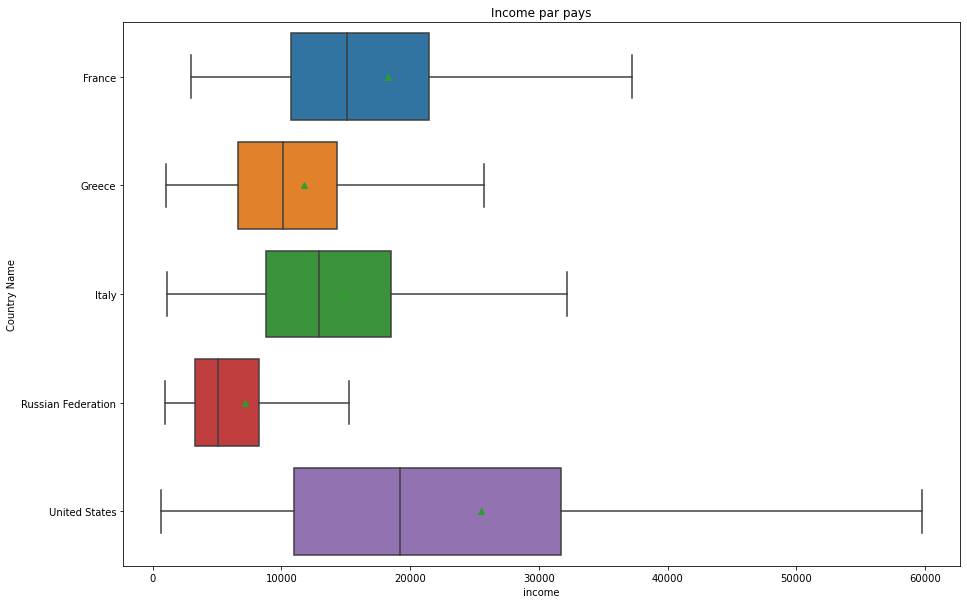

In [417]:
plt.figure(figsize=(15,10))
sns.boxplot(
    data=sample[sample['country'].isin(pays_panel)], 
    x='income', y='Country Name', 
    showfliers=False, showmeans=True)
plt.title('Income par pays')
plt.savefig("P7_02_graphics/'INCOME'.jpeg")    
plt.show()

In [418]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot

# Assumption Check

**Parametric test assumptions :** - Population distributions are normal - Samples have equal variances

In [419]:
lm = ols('income ~ country', data=sample).fit()

La p-value inférieure à 5% permet d'accepter l'hypothèse 1 : une ou plusieurs des moyennes de revenus sont différentes entre pays.

Le pays et le revenu des enfants seraient donc corrélés, mais on doit vérifier certaines conditions avant de valider l'ANOVA :

La normalité des résidus

L'homoscédasticité des résidus (homogénéité des variances)

 S'il n'y a pas de variances égales entre les groupes, il y a plusieurs solutions à envisager : 

- Utiliser un test statistique non paramétrique - Transformer les données.

In [420]:
def test_anova(lm):
    anova_table = sm.stats.anova_lm(lm, typ=2)
    p = anova_table['PR(>F)'][0]
    print('ANOVA\n', anova_table)
    print(
        '\np-value :', p, 
        '\nstat (F) :', anova_table['F'][0])
    if p > 0.05:
        print('H0: the means of the samples are equal')
    else:
        print('H1: one or more of the means of the samples are unequal')
    
test_anova(lm)

ANOVA
                 sum_sq         df           F  PR(>F)
country   2.522290e+14       64.0  954.149829     0.0
Residual  1.342373e+16  3249935.0         NaN     NaN

p-value : 0.0 
stat (F) : 954.1498287436316
H1: one or more of the means of the samples are unequal


Le test de Shapiro renvoie une p-value de 0% : la distribution des résidus n'est probablement pas normale.

Test de Shapiro :

stats : 0.18091219663619995 
p-value : 0.0
H1 rejetée : distribution probablement pas normale


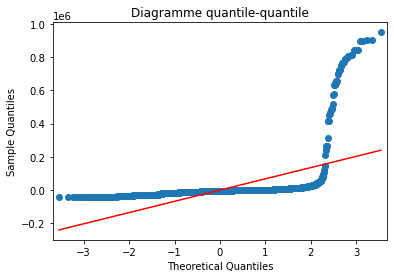

In [421]:
def test_shapiro(data):
    shapiro_table = stats.shapiro(data)
    p = shapiro_table[1]
    print('Test de Shapiro :')
    print('\nstats :', shapiro_table[0],
        '\np-value :', p)
    if p>.05:
        print('H0 acceptée : distribution normale')
    else:
        print('H1 rejetée : distribution probablement pas normale')

    qqplot(data, line='s')
    plt.title('Diagramme quantile-quantile')
    plt.savefig("P7_02_graphics/'Diagramme quantile-quantile'.jpeg") 
    plt.show()
    
test_shapiro(lm.resid.sample(5000))

- S'appuyer sur le théorème de la limite centrale si la taille de l'échantillon est suffisamment grande (≥ 30) - Transformer les données - Utiliser un test statistique non paramétrique La transformation des données peut également aider si l'hypothèse d'égalité des variances est violée.

# Homoscedasticity

Comme pour le test de l'hypothèse de normalité, il existe quelques tests statistiques pour tester l'hypothèse d'égalité des variances. Parmi les méthodes les plus courantes, citons le test de Barlett et le test de Levene pour l'égalité des variances. Le choix du test correct dépend également de l'hypothèse de normalité. Par exemple, le test de Barlett s'est révélé sensible aux écarts par rapport à la normalité, tandis que le test de Levene y est moins sensible (Conover, 1981).

L'homogénéité des résidus peut être mesurée avec le test de Levene. On obtient une p-value inférieure à 5 %, validant l'hypothèse 1 : les variances des groupes sont différentes, il n'y a donc pas d'homoscédasticité, requise par l'ANOVA.

In [422]:
import scipy
import scipy.stats

In [423]:
import pingouin as pg

In [424]:
pg.homoscedasticity(df, dv='income', group='Country Name')

,W,pval,equal_var
levene,1.911713,0.000018,False


Test de Levene est une statistique déductive utilisée pour évaluer l'égalité de variance pour une variable calculée pour deux groupes ou plus1.

Certaines procédures statistiques courantes supposent que les variances des populations à partir desquelles différents échantillons sont prélevés sont égales. Le test de Levene évalue cette hypothèse. Il teste l'hypothèse nulle que les variances de population sont égales (appelées « homogénéité de la variance » ou homoscédasticité). Si la valeur p résultante du test de Levene est inférieure à un niveau de signification (typiquement 0,05), il est peu probable que les différences obtenues dans les variances d'échantillon se soient produites sur la base d'un échantillonnage aléatoire d'une population à variances égales. Ainsi, l'hypothèse nulle d'égale variance est rejetée et il est conclu qu'il existe une différence entre les variances dans la population.

Comme alternative à l'ANOVA, on peut utiliser le test non paramétrique de Kruskal-Wallis quand ni la normalité ni l'homoscédasticité ne peuvent être vérifiées.



In [425]:
pg.kruskal(sample, dv='income', between='Country Name')

,Source,ddof1,H,p-unc
Kruskal,Country Name,64,2.327230e+06,0.0


La p-value est encore inférieure à 5%, et valide l'ANOVA précédente : les revenus moyens diffèrent bien entre pays.

**Variables au logarithme**

Pour chacune des régressions suivantes, on testera 2 versions : l'une en exprimant le revenu moyen du pays et les revenus (parents & enfants) en logarithme (ln), l'autre en les laissant tels quels. On choisira la version la plus performante.

On passe d'abord certaines variables au logarithme (inverse de l'exponentielle) pour en créer de nouvelles. Les valeurs sont centrées et réduites. On ne convertit pas gini et IGE, dont les variables sont déjà à échelle.

In [426]:
sample['income_ln'] = np.log(sample['income'])
sample['income_mean_ln'] = np.log(sample['income_mean'])
sample['population_ln'] = np.log(sample['population'])
sample['gdpppp_ln'] = np.log(sample['gdpppp'])
sample

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,region,IGE,income_mean,c_i_parent,gini_y,income_ln,income_mean_ln,population_ln,gdpppp_ln
0,ALB,2008,1,100,728.89795,7297.00000,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,14,30.0,6.591534,8.004643,14.896405,8.895219
1,ALB,2008,2,100,916.66235,7297.00000,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,28,30.0,6.820739,8.004643,14.896405,8.895219
2,ALB,2008,3,100,1010.91600,7297.00000,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,92,30.0,6.918612,8.004643,14.896405,8.895219
3,ALB,2008,4,100,1086.90780,7297.00000,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,65,30.0,6.991092,8.004643,14.896405,8.895219
4,ALB,2008,5,100,1132.69970,7297.00000,Albania,2947314,Europe & Central Asia,0.815874,2994.829902,14,30.0,7.032359,8.004643,14.896405,8.895219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3249995,COD,2008,96,100,810.62330,303.19305,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324,78,42.2,6.697803,8.949275,17.916685,5.714370
3249996,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324,14,42.2,6.815402,8.949275,17.916685,5.714370
3249997,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324,10,42.2,6.963954,8.949275,17.916685,5.714370
3249998,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep.",60411195,Sub-Saharan Africa,0.707703,7702.302324,76,42.2,7.159761,8.949275,17.916685,5.714370


Projetées sur un nuage de points, les variables montrent des droites de régression plus ou moins marquées : le revenu moyen et le PPA semblent avoir des relations plus linéaires avec le revenu des individus. On peut potentiellement mieux prédire les données avec ces variables.

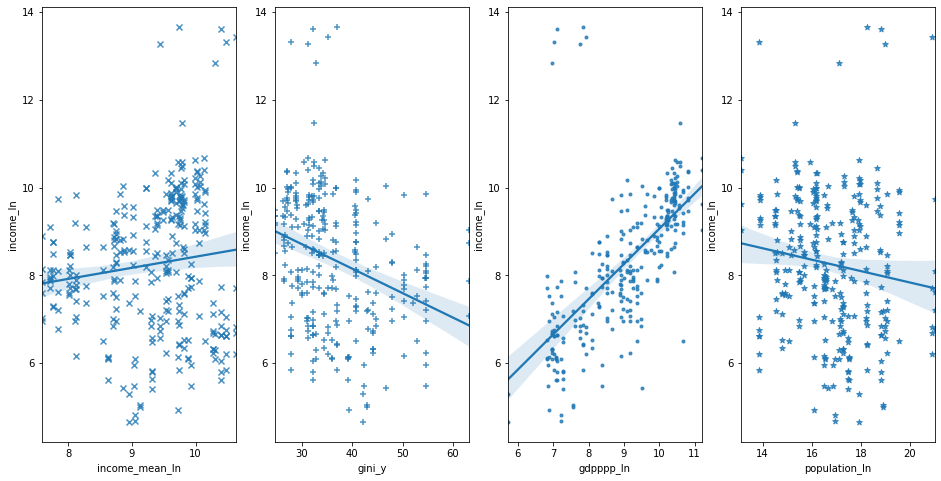

In [427]:
sample_regplots = sample.sample(300)
fig, ax = plt.subplots(1, 4, figsize=(16,8))
sns.regplot(data=sample_regplots, x='income_mean_ln', y='income_ln', marker='x', ax=ax[0])
plt.savefig("P7_02_graphics/'regplot1'.jpeg") 
sns.regplot(data=sample_regplots, x='gini_y', y='income_ln', marker='+', ax=ax[1])
plt.savefig("P7_02_graphics/'regplot2'.jpeg") 
sns.regplot(data=sample_regplots, x='gdpppp_ln', y='income_ln', marker='.', ax=ax[2])
plt.savefig("P7_02_graphics/'regplot3'.jpeg") 
sns.regplot(data=sample_regplots, x='population_ln', y='income_ln', marker='*', ax=ax[3])
plt.savefig("P7_02_graphics/'regplot4'.jpeg") 

plt.show()

**Revenu moyen + Gini**

On n'inclut d'abord dans la régression que 2 variables explicatives : le revenu moyen du pays de l’individu, et son indice de Gini.

**Avec logarithme**

On teste un premier modèle avec les variables passées au logarithme. On verra que des variables à la même échelle renforcent la performance du modèle. Le résumé fournit plusieurs indicateurs clés :

**R-squared (R2) mesure la qualité de prédiction d'une régression linéaire :**

 c'est la variance des résidus
 
 on peut la nommer variance expliquée, décomposition de variance totale ou coefficient de détermination
 
 elle doit idéalement s'approcher de 1
 
Dans le deuxième tableau, on trouve le coefficient de régression (**coef**) de la variable concernée :

 la valeur prédite sera égale la somme de tous les valeurs explicatives, multipliées par leurs coefficients de variable       respectifs
 
 l'objectif de la régression sera de trouver la combinaison de coefficients expliquant le maximum de variance

**P>[t] indique la significativité de ce coefficient :**

 plus cette p-value sera élevée, moins la variable sera intéressante
 
 elle mesure la significativité des coefficients de variables (colonne coef)
 
**Cond. No. mesure la colinéarité des variables :**

 plus sa valeur est grande, plus il y a de colinéarité
 
 la multicolinéarité affecte la peformance d'un modèle : on cherchera la valeur la plus basse possible
 
 le VIF (variance inflation factor) est un outil plus précis pour mesurer la multicolinéarité
 


In [428]:
model_mini_ln = smf.ols(formula='income_ln ~ income_mean_ln + gini_y', data=sample).fit()
print(model_mini_ln.summary())

                            OLS Regression Results                            
Dep. Variable:              income_ln   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                 2.173e+05
Date:                Sun, 13 Mar 2022   Prob (F-statistic):               0.00
Time:                        12:10:12   Log-Likelihood:            -5.6038e+06
No. Observations:             3150000   AIC:                         1.121e+07
Df Residuals:                 3149997   BIC:                         1.121e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.6849      0.011    698.

Ici, avec les variables au logarithme on constate que :

 le modèle explique 12% de la variance
 
  les 2 variables contribuent toutes deux aux modèle, avec un P>|t| à 0
  
 le coefficient de significativité du revenu moyen est positif, tandis que celui du Gini est négatif. Plus l'indice de Gini sera haut (signe d'inégalité), plus le revenu prédit sera faible.

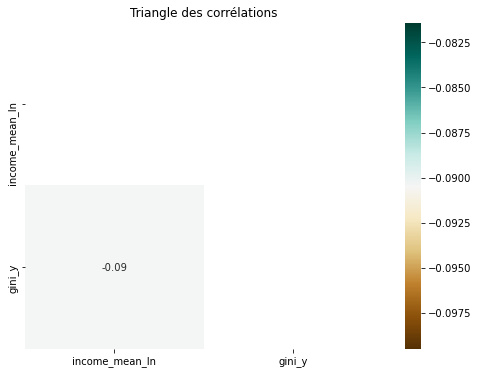

In [429]:
correlation_matrix = sample[['income_mean_ln', 'gini_y']].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='BrBG')
plt.title('Triangle des corrélations')
plt.savefig("P7_02_graphics/'Triangle des corrélations'.jpeg") 
plt.show()

La matrice des corrélations confirme une corrélation modérée et negative entre les deux explicatives (plus l'indice de Gini est bas, plus le revenu moyen a tendance à être haut).

Pour accepter une régression linéaire, on veut que ses rédidus soient distribués normalement. Les résidus du QQ plot montre qu'elle s'en approche, mais les outliers empêchent de qualifier la distribution de normale.

Test de Shapiro :

stats : 0.9702736139297485 
p-value : 5.501410892780554e-31
H1 rejetée : distribution probablement pas normale


<Figure size 432x288 with 0 Axes>

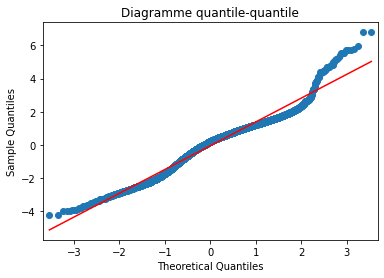

In [430]:
residus = model_mini_ln.resid.sample(5000)
plt.savefig("P7_02_graphics/'Diagrramme quantile'.jpeg") 
test_shapiro(residus)

Les données avec d'importants résidus (données aberrantes) et/ou fort effet de levier peuvent fausser le résultat et la précision d'une régression. Le z-score permet de normaliser la position des outliers.

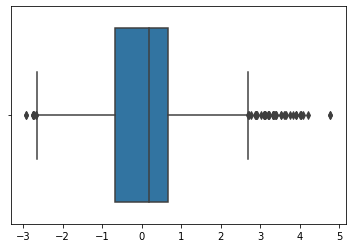

In [431]:
residus_zscore = pd.Series(stats.zscore(residus))
sns.boxplot(residus_zscore)
plt.savefig("P7_02_graphics/'residus_zscore'.jpeg") 
plt.show()

On peut alors ne sélectionner que les résidus ayant un z-score au-dessous d'un certain seuil.

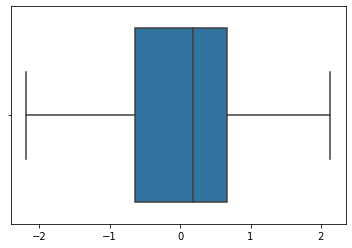

In [432]:
residus_zscore = residus_zscore[abs(residus_zscore) < 2.2].dropna()
sns.boxplot(residus_zscore)
plt.savefig("P7_02_graphics/'residus_zscore'.jpeg") 
plt.show()

La p-value du test de Shapiro ne suffit pas à rejeter l'hypothèse, mais le QQ plot montre des résidus toujours plus proches de la normale.

Test de Shapiro :

stats : 0.9633838534355164 
p-value : 1.8110158207027568e-33
H1 rejetée : distribution probablement pas normale


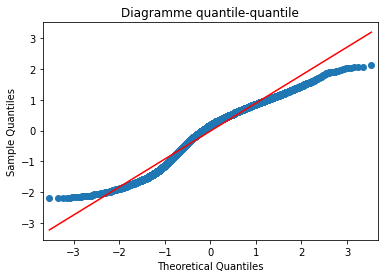

In [433]:

test_shapiro(residus_zscore)


In [434]:
model_mini = smf.ols(formula='income ~ income_mean + gini_y', data=sample).fit()
print(model_mini.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                 3.072e+04
Date:                Sun, 13 Mar 2022   Prob (F-statistic):               0.00
Time:                        12:10:15   Log-Likelihood:            -3.9320e+07
No. Observations:             3150000   AIC:                         7.864e+07
Df Residuals:                 3149997   BIC:                         7.864e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     1.44e-09    177.203   8.13e-12      

**Sans logarithme**


En passant des 2 variables dans le modèle, on obtient une variance des résidus (R-squared) plus faible. L'échelle des valeurs de income_mean a trop poids face à celles de gini :

 - la variance des résidus est beaucoup moins élévée qu'avec le modèle précédent
 
 - la variable gini n'est plus significative (p-value de 1)
 
 - income_mean explique à elle seule le modèle (p-value de 0)

 - la colinéarité est beaucoup plus forte que précédemment (le modèle renvoie d'ailleurs un avertissement cette fois-ci)

 - le coefficient de la seule variable significative (income_mean) passe à 1 : pas besoin de multiplier sa valeur vu qu'elle est    la seule avec l'intercept dans la formule de régression.

La distribution des résidus s'éloigne beaucoup plus de la normale qu'avec le modèle précédent. La régression linéaire a besoin d'une distribution normale des résidus, les données passées au logarithme sont donc là encore plus pertinentes.

Test de Shapiro :

stats : 0.1858382225036621 
p-value : 0.0
H1 rejetée : distribution probablement pas normale


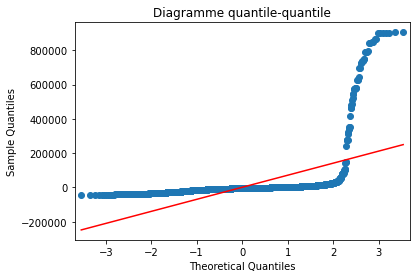

In [435]:
residus = model_mini.resid.sample(5000)

test_shapiro(residus)

# **Ajout de la classe parents**

# Avec logarithme

In [436]:
model_ln = smf.ols(formula='income_ln ~ income_mean_ln + gini_y + c_i_parent', data=sample).fit()
print(model_ln.summary())

                            OLS Regression Results                            
Dep. Variable:              income_ln   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                 1.449e+05
Date:                Sun, 13 Mar 2022   Prob (F-statistic):               0.00
Time:                        12:10:18   Log-Likelihood:            -5.6038e+06
No. Observations:             3150000   AIC:                         1.121e+07
Df Residuals:                 3149996   BIC:                         1.121e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.6847      0.011    692.


En ajoutant juste la classe parents, on obtient une variance expliquée égale à celle obtenue plus tôt sans cette variable. 

Income_mean_ln et gini_ln sont toujours aussi significatives, mais la classe parents obtient une P>|t| de 92 %, indiquant une probable absence de significativé de cette variable.

Le modèle explique la même variance que sans la classe parent, mais la colinéarité est plus forte : mieux vaut donc ne pas choisir cette variable comme explicative pour renforcer la robustesse du modèle.

In [437]:
model = smf.ols(formula='income ~ income_mean + gini_y + c_i_parent', data=sample).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                 2.048e+04
Date:                Sun, 13 Mar 2022   Prob (F-statistic):               0.00
Time:                        12:10:20   Log-Likelihood:            -3.9320e+07
No. Observations:             3150000   AIC:                         7.864e+07
Df Residuals:                 3149996   BIC:                         7.864e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      15.3096    188.061      0.081      

**Sans logarithme**


Sans logarithme, la variance expliquée est mois que précédemment, qu'on ajoute c_i_parent ou non. 

L'indice de Gini garde la même absence de significativité, comme c_i_parent. Le revenu moyen reste la seule variable significative.

In [438]:
model_full = smf.ols(formula='income_ln ~ income_mean_ln + gini_y + gdpppp_ln + population_ln + IGE', data=sample).fit()
print(model_full.summary())

                            OLS Regression Results                            
Dep. Variable:              income_ln   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                 9.010e+05
Date:                Sun, 13 Mar 2022   Prob (F-statistic):               0.00
Time:                        12:10:22   Log-Likelihood:            -4.4088e+06
No. Observations:             3150000   AIC:                         8.818e+06
Df Residuals:                 3149994   BIC:                         8.818e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.2087      0.012   -104.

**Optimisation**


On a vu que passer les variables au logarithme renforce la robustesse du modèle, et que les variables n'apportant pas de variance expliquée peuvent au contraire renforcer la colinéarité.

En ajoutant d'autres variables explicatives à notre premier modèle (income_ln + gini_ln), on n'obtient aucune amélioration du modèle :

le R-squared est  (0.589)
même si toutes les features sont significatives (toutes les P>|t| à 0%)
la colinéarité est par contre plus forte (908 contre 530 pour le premier modèle)

# Conclusion
Les meilleurs résultats ont été obtenus en n'incluant que le revenu moyen du pays et son indice de Gini passés au logarithme.

Le revenu moyen explique la majeure partie de la variance, que l'indice de Gini vient affiner en réduisant la valeur prédite quand l'inégalité est forte.

Notre modèle explique environ 60% de la variance : la variance non expliquée peut être liée à des caractères indisponibles comme le niveau d'études, le sexe, la classe sociale, le hasard, etc. De nouvelles variables pourraient donc améliorer notre modèle, mais en l'état seules deux variables auront suffi pour obtenir la meilleure performance avec ce jeu de données.